# Week 4 - Counting Words & Phrases

This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words, simple and parsed phrases and explore the statistical properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the correlation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora. 

Then we shift to focus not simply on the *ideas* in a corpus, but also extracting precise *claims*. This process involves a sequential pipeline of classifying and structuring tokens from text, each of which generates potentially useful data for the content analyst. Steps in this process, which we examine in this notebook, include: 1) tagging words by their part of speech (POS) to reveal the linguistic role they play in the sentence (e.g., Verb, Noun, Adjective, etc.); 2) tagging words as named entities (NER) such as places or organizations; 3) structuring or "parsing" sentences into nested phrases that are local to, describe or depend on one another; and 4) extracting informational claims from those phrases.

We will be introducing spaCy as a package for Computational Linguistics, and also walk you through how to use the Davies Corpora. 

While we wish to avoid using NLTK for heavy corpus analysis, some of its smaller functions can still be useful.

Of course, for final projects that draw on these tools, we encourage you to install the software on your own machines or shared servers at the university (RCC, SSRC) in order to perform these operations on much more text. 

For this notebook we will be using the following packages:


In [4]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud_2020 #pip install git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import requests #for http requests
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

# comp-linguistics
import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

# Retrieving exemplary corpora

To get started we will need some examples. Let's start by downloading one of the corpuses from the Davies set purchased for this class and developed by a computational linguist at Brigham Young University. We can get a list of works available from the [corpora here](https://www.english-corpora.org/).

In this notebook, I will be accessing the data locally - you also have access to this data through the Dropbox download link. The same code can be modified slighlty to access the rest of the corpora on RCC. 
There is a notebook describing this process in the same repository, as well as in the same directory on RCC.

In [2]:
corpus_name = "/Users/bhargavvader/Downloads/Movies"
# corpus_name = "Movies"

This method extracts the text from the zip files and stroes the raw data.

In [3]:
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

In [4]:
movie_raw = loadcorpus(corpus_name)

text_13_idi.zip
text_16_qll.zip
text_32_ldf.zip
text_19_gvc.zip
text_05_nko.zip
text_17_arp.zip
text_01_ote.zip
text_28_rfy.zip
text_31_akv.zip
text_22_etp.zip
text_11_uoy.zip
text_09_oii.zip
text_06_jfy.zip
text_14_lnc.zip
text_08_loh.zip
text_33_kje.zip
text_30_wkp.zip
text_07_oma.zip
text_03_mnq.zip
text_21_fqa.zip
text_29_oye.zip
text_27_fle.zip
text_23_fmh.zip
text_12_rcq.zip
text_00_myn.zip
text_10_aoy.zip
text_04_mlq.zip
text_20_cde.zip
text_02_mqu.zip
text_26_ngj.zip
text_24_ywo.zip
text_18_jfj.zip
text_25_byg.zip
text_15_guo.zip


In [5]:
movie_raw['11.txt'][0:3]

[b'\r\n',
 b'@@216680 Hey , I \'m talking to you Give me 600 dollars You wish ! That \'s all we \'ve left And you still go to gamble Shut up I earn the money Even that you ca n\'t take it for gamble Shut up What \'re you doing ? Bastard , I \'m gon na beat you You gambling pig , I \'ll beat the shit out of you You bitch I \'ll beat you You dare to hit me with something ! I \'ll kill you All you know is gambling I \'ll beat you What \'re you doing ? Let go of me Stop You \'ll kill Mom Mom , are you all right ? Do n\'t touch my money Dad , where \'re you going ? Go away Dad , do n\'t go Get lost Dad , come back You take Marble with you The way she \'s now Do you want to give me trouble ? I \'m in more trouble than you I am a woman I \'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Do n\'t marry a gambler Hey , 

It seems messy, but nothing we can't clean. This basic method replaces some of the issues with the formatting, and prints the errors if any for debugging. Let us clean one of the raw text files.

We ignore the non-unicode data for convenience in our first pass.

In [6]:
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

In [7]:
clean_11 = clean_raw_text(movie_raw['11.txt'])

In [8]:
clean_11[1]

'@@216680 Hey , I\'m talking to you Give me 600 dollars You wish ! That\'s all we\'ve left And you still go to gamble Shut up I earn the money Even that you can\'t take it for gamble Shut up What\'re you doing ? Bastard , I\'m gon na beat you You gambling pig , I\'ll beat the shit out of you You bitch I\'ll beat you You dare to hit me with something ! I\'ll kill you All you know is gambling I\'ll beat you What\'re you doing ? Let go of me Stop You\'ll kill Mom Mom , are you all right ? Don\'t touch my money Dad , where\'re you going ? Go away Dad , don\'t go Get lost Dad , come back You take Marble with you The way she\'s now Do you want to give me trouble ? I\'m in more trouble than you I am a woman I\'m a sailor You take care of Marble Just gamble a bit less is enough to raise the kid No way Raising her would be like raising others @ @ @ @ @ @ @ @ @ @ take care of her Marry her when she grows up And you tell her to be smart Don\'t marry a gambler Hey , you want a quarrel ? No , never

This method cleaned a few basic formatting errors. You are welcome to experiment and add your own code to expand on cleaning the text. Once it begins to look the way you want it to, we can start using spaCy to do some heavier cleaning. spaCy does this through the use of language models. Make sure you have the spaCy english language model loaded. 

In [9]:
nlp = spacy.load("en")

This model is going to be the basis of most of the tasks which NLTK (the Natural Language Tool Kit) might have done otherwise. While NLTK uses a bunch of clunky models from multiple places, spacy neatly packs all functionality in one model. This deep trained model will start by doing our word tokenizing and normalising. These methods are already included in lucem illud, and here we will just demonstrate them outside the package so to explain what goes on under the hood.

When we run text through a spacy model, it performs a lot of computation on each of the tokens. Each token is given certain attributes, such as a part of speech, information whether it is a number, a stop word, and so on. 

To perform a tokenization, we check if the string includes punctuation and add this token. 

In [10]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [11]:
word_tokenize(clean_11[1])

['@@216680',
 'Hey',
 'I',
 "'m",
 'talking',
 'to',
 'you',
 'Give',
 'me',
 '600',
 'dollars',
 'You',
 'wish',
 'That',
 "'s",
 'all',
 'we',
 "'ve",
 'left',
 'And',
 'you',
 'still',
 'go',
 'to',
 'gamble',
 'Shut',
 'up',
 'I',
 'earn',
 'the',
 'money',
 'Even',
 'that',
 'you',
 'ca',
 "n't",
 'take',
 'it',
 'for',
 'gamble',
 'Shut',
 'up',
 'What',
 "'re",
 'you',
 'doing',
 'Bastard',
 'I',
 "'m",
 'gon',
 'na',
 'beat',
 'you',
 'You',
 'gambling',
 'pig',
 'I',
 "'ll",
 'beat',
 'the',
 'shit',
 'out',
 'of',
 'you',
 'You',
 'bitch',
 'I',
 "'ll",
 'beat',
 'you',
 'You',
 'dare',
 'to',
 'hit',
 'me',
 'with',
 'something',
 'I',
 "'ll",
 'kill',
 'you',
 'All',
 'you',
 'know',
 'is',
 'gambling',
 'I',
 "'ll",
 'beat',
 'you',
 'What',
 "'re",
 'you',
 'doing',
 'Let',
 'go',
 'of',
 'me',
 'Stop',
 'You',
 "'ll",
 'kill',
 'Mom',
 'Mom',
 'are',
 'you',
 'all',
 'right',
 'Do',
 "n't",
 'touch',
 'my',
 'money',
 'Dad',
 'where',
 "'re",
 'you',
 'going',
 'Go',
 'a

You can see how the sentence is broken into its constituent words. We can then do some analysis with this. 

Note: we still don't know which movie this is, just that it is raw movie text data. Maybe in the process of our text cleaning and counting we will come across something!

# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [12]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

In [13]:
countedWords = wordCounter(word_tokenize(clean_11[1]))
countedWords[:10]

,count,word
0,1,exposed
1,1,mistresses
2,3,gamble
3,1,single
4,2,recover
5,4,does
6,2,relax
7,39,of
8,4,once
9,2,fit


Lets sort and plot our counts to investigate the shape of our word frequency distribution.

First we need to sort the words by count.

In [14]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

,count,word
867,302,you
573,191,i
719,126,'s
464,112,to
162,109,it
454,106,the
251,106,n't
299,93,do
87,85,a
927,82,me


Punctuation and very common words (articles 'a' and 'the'; prepositions 'of' and 'to') make up the most common values, but this isn't very interesting and can actually get in the way of our analysis. We may remove these 'function words' by removing according to a stopword list, setting some frequency threshold, or using a weighting scheme (like tf.idf) to decrease their influence - we will look at these methods in more detail as we go through this tutorial. 

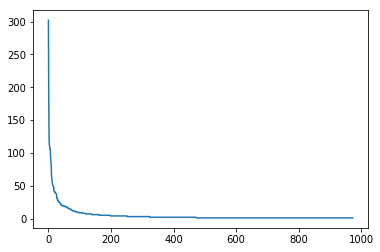

In [15]:
#Creating a figure and axis lets us do things like change the scaling or add a title
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

This shows that likelihood of a word occurring is inversely proportional to its rank. This effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), and suggests that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log (rank order) and log (frequency) resulting in a linear relationship.

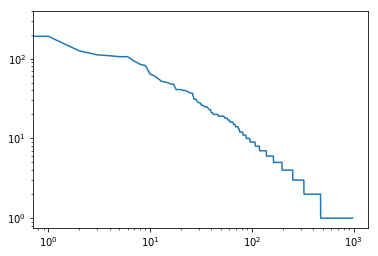

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

(The same relationship occurs in many other rankings, such as population ranks of cities, corporation sizes, income rankings, etc.) 

The distribution was imagined by Zipf to be driven by a principle of 'least effort' where speakers did not work any harder than necessary to communicate a given idea, but the basis for this relationship is still not well understood and conforms at least as well to a process of [preferential attachment](https://en.wikipedia.org/wiki/Preferential_attachment) whereby people disproportionately attend to popular words.


# Getting and working with raw text

First, we will retrieve a collection of press releases from a *GitHub API* that archived them, based on a number of analyses by Justin Grimmer, a political scientist whose work we will read in two weeks!

GitHub API requests are made to `'https://api.github.com/'` and responses are in JSON, similar to Tumblr's API.

We will get the information on [github.com/lintool/GrimmerSenatePressReleases](https://github.com/lintool/GrimmerSenatePressReleases) as it contains a nice set documents.

In [17]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases')
senateReleasesData = json.loads(r.text)
print(senateReleasesData.keys())
print(senateReleasesData['description'])

dict_keys(['git_tags_url', 'keys_url', 'pulls_url', 'blobs_url', 'clone_url', 'owner', 'downloads_url', 'private', 'default_branch', 'watchers_count', 'has_downloads', 'archived', 'issue_comment_url', 'temp_clone_token', 'collaborators_url', 'teams_url', 'subscribers_count', 'has_pages', 'mirror_url', 'subscription_url', 'git_url', 'has_issues', 'updated_at', 'statuses_url', 'stargazers_url', 'disabled', 'git_refs_url', 'language', 'compare_url', 'tags_url', 'languages_url', 'assignees_url', 'created_at', 'pushed_at', 'labels_url', 'open_issues', 'node_id', 'open_issues_count', 'has_projects', 'html_url', 'deployments_url', 'hooks_url', 'homepage', 'ssh_url', 'forks', 'url', 'stargazers_count', 'size', 'branches_url', 'has_wiki', 'license', 'releases_url', 'subscribers_url', 'commits_url', 'issue_events_url', 'contents_url', 'forks_count', 'full_name', 'issues_url', 'id', 'fork', 'archive_url', 'contributors_url', 'notifications_url', 'network_count', 'watchers', 'comments_url', 'name'

What we are interested in here is the `'contents_url'`

In [18]:
print(senateReleasesData['contents_url'])

https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/{+path}


We can use this to get any or all of the files from the repo.

In [19]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse')
whitehouseLinks = json.loads(r.text)
whitehouseLinks[0]

{'_links': {'git': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
  'html': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
  'self': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master'},
 'download_url': 'https://raw.githubusercontent.com/lintool/GrimmerSenatePressReleases/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'git_url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
 'html_url': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'name': '10Apr2007Whitehouse123.txt',
 'path': 'raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'sha': 'f524289ee563dca58690c8d36c23dce5dbd9962a',
 'size': 2206,
 'type': 'file',
 'url': 'https://api.github.com/r

Now we have a list of information about Whitehouse press releases. Let's look at one of them.

In [20]:
r = requests.get(whitehouseLinks[0]['download_url'])
whitehouseRelease = r.text
print(whitehouseRelease[:1000])
len(whitehouseRelease)

SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY IN PUSH FOR STEM CELL RESEARCH
  Sharing the story of Lila Barber, a 12 year old girl from Westerly, Sen. Sheldon Whitehouse (D-R.I.) on Tuesday, April 10, 2007, illustrated the hope stem cell research can offer in a speech on the Senate floor in favor of legislation to expand federal funding for stem cell research.  
   Whitehouse met Lila two weeks ago. She was diagnosed two years ago with osteosarcoma, a cancerous bone condition, and last year underwent cadaver bone transplant surgery. The procedure saved her leg and is helping her remain cancer-free, but the transplanted tissue will not grow with her and likely will break down over time. Stem cell research, Whitehouse explained, could vastly improve the care of patients like Lila by allowing surgeons to enhance transplants with a patient's own stem cells, which could replace the lost bone and cartilage, or grow entirely new replacement bones and joints. 
   "Stem cell research gives hope

2206

Now we have a string of correctly encoded text. For analysis of its words, next we need to tokenize it, or split it into a sequence of tokens or word instances.

In [21]:
whTokens = word_tokenize(whitehouseRelease)
whTokens[10:30]

['STEM',
 'CELL',
 'RESEARCH',
 'Sharing',
 'the',
 'story',
 'of',
 'Lila',
 'Barber',
 'a',
 '12',
 'year',
 'old',
 'girl',
 'from',
 'Westerly',
 'Sen.',
 'Sheldon',
 'Whitehouse',
 'D']

Previous iterations of the course used `nltk`s tokenizer, but as we saw before, we used spaCy's model (https://spacy.io/api/tokenizer). We intend to avoid using NLTK when we can - for production level code, it is a lot faster and cleaner to use spaCy.

That being said, `nltk` does have some useful methods for quick analysis of small corpora. We will explore a few here, and encourage you to figure out for yourself which other ones might be useful.

To use the list of tokens in `nltk`, and take advantage of functions like `concordance`, shown above, we can convert it into a `Text`.

In [22]:
import nltk

In [23]:
whText = nltk.Text(whTokens)

whitehouseIndex = nltk.text.ConcordanceIndex(whText) 
whitehouseIndex.print_concordance('Whitehouse')

Displaying 5 of 5 matches:
ld girl from Westerly Sen. Sheldon Whitehouse D R.I. on Tuesday April 10 2007 il
ral funding for stem cell research Whitehouse met Lila two weeks ago She was dia
 down over time Stem cell research Whitehouse explained could vastly improve the
s research might help or even cure Whitehouse said Whitehouse also praised the e
 help or even cure Whitehouse said Whitehouse also praised the efforts of Rhode 


*Note* that the `Text` class is for doing rapid, exploratory analysis. It provides an easy interface to many of the operations we want to do, but it does not allow us much control over the particular operations it glosses. When you are doing a more complete analysis, you should be using the module specifically designed for that task instead of the shortcut method `Text` provides, e.g. use  [`collocations` Module](http://www.nltk.org/api/nltk.html#module-nltk.collocations) instead of `.collocations()`.

Now that we have gotten this loaded, let's glance at few features we will delve into more deeply later.

For example, we can find words that statistically tend to occur together and typically have a composite, idiomatic meaning irreducible to the semantics of its component words. We will do this later with more control over exactly how these are identified.

Or we can pick a word (or words) and find what words tend to occur around it.

In [24]:
whText.common_contexts(['stem'])

time_cell own_cells hope_cell joints_cell for_cell on_cells of_cell
the_cell embryonic_cells


We can also just count the number of times the word occurs.

In [25]:
whText.count('cell')

5


We can also plot each time a set of words occurs.

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


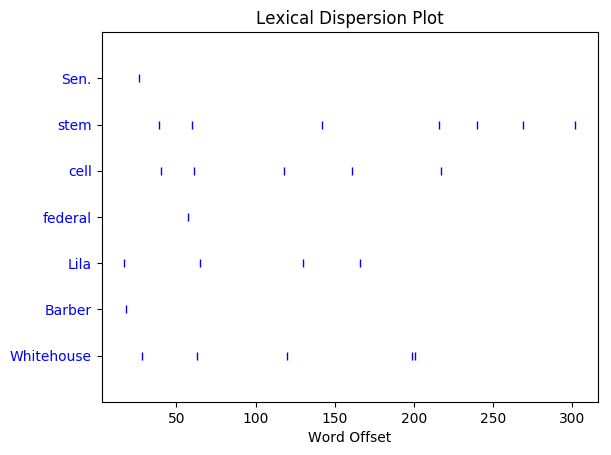

In [26]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Sen.','stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])
sns.set() #Re-enabling seaborn

If we want to do an analysis of all the Whitehouse press releases we will first need to obtain them. By looking at the API we can see the the URL we want is [https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse](https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse), so we can create a function to scrape the individual files.

If you want to know more about downloading from APIs, refer back to the 1st notebook.

In [27]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

whReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse', maxFiles = 10)
whReleases[:5]

,download_url,html_url,name,path,text
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Whitehouse123.txt,raw/Whitehouse/10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Whitehouse2.txt,raw/Whitehouse/10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Whitehouse3.txt,raw/Whitehouse/10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2007Whitehouse78.txt,raw/Whitehouse/10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jan2008Whitehouse35.txt,raw/Whitehouse/10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...


If you are having trouble downloading the data uncomment this next cell

In [48]:
#whReleases = pandas.read_csv('../data/whReleases.csv')

Now we have all the texts in a DataFrame we can look at a few things.

First let's tokenize the texts with the same tokenizer as we used before. We will just save the tokens as a list for now; no need to convert to `Text`s.

In [29]:
whReleases['tokenized_text'] = whReleases['text'].apply(lambda x: word_tokenize(x))

Now lets see how long each of the press releases is:

In [30]:
whReleases['word_counts'] = whReleases['tokenized_text'].apply(lambda x: len(x))
whReleases['word_counts']

0    350
1    311
2    497
3    189
4    236
5    334
6    241
7    469
8    443
9    425
Name: word_counts, dtype: int64

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. This could include one of the Davies corpora or some other you have constructed. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </span>

## Please see Canvas pitch submission for more information on the data I am using. 

In [5]:
with open("/Users/Sruti/Downloads/Composite.txt") as f:
    tyb_transcripts = f.read()
#contains 12 transcripts from the Thank you Because Project (Chu Zhuang and I are using this data for our final project)

#with open(corpus_abstractsOH, mode='r', encoding='utf-8') as f:
tyb_transcripts

'5\nPerson A  0:01  \nOkay, so uh, I guess they said we should start? \n\nPerson B  0:03  \nYea, we should start\n\nPerson A  0:05  \nSo uh they said that this is a topic we disagreed on. So I\'m guessing you said that it shouldn\'t be abolished? \n\nPerson B  0:10  \nUm, yeah.\n\nPerson A  0:10  \nUm I guess I\'d like to hear you talk about it\n\nPerson B  0:18  \nI actually didn\'t look much into the legal system here, but for death penalty, I think like, if..I think if someone committed to a really serious crime such as umm very like, like murdering people and like not being regretful about that and then um like continuously doing a lot of things that will harm the security of the society and also the people around them. I don\'t think there is any reason why this person could continue to live in this society,\n\nPerson A  1:01  \nYeah, like definitely, like, I definitely see what you mean what the reason I personally am against the death penalty isn\'t because I don\'t think some p

In [84]:
import re
file_num=['5','6','7','8','9','11','12','13','54','55','58','59']
condition=['NB','TYB','NB','TYB','TYB','TYB','NB','NB','TYB','TYB','TYB','NB']
conversation_txt_all=[]
conversation_txt_A_all=[]
conversation_txt_B_all=[]
    
for i in range(12):
    filename=file_num[i]+'_otter.ai.txt'
    with open(filename, encoding='utf-8') as f:
        lines=f.readlines()
    
    conversation_txt=[]
    conversation_txt_A=[]
    conversation_txt_B=[]
    for line in lines[:-1]:
        re_person=r'Person (A|B)'
        find_person=re.search(re_person,line)
        if find_person:
            person_id=find_person.group(1)
        else:
            line=re.sub(r'\n','',line)
            if line:
                #print(line)
                conversation_txt.append(line)        
                if person_id=='A':
                    conversation_txt_A.append(line)
                elif person_id=='B':
                    conversation_txt_B.append(line)
                    
    conversation_txt=' '.join(conversation_txt)       
    conversation_txt_A=' '.join(conversation_txt_A)    
    conversation_txt_B=' '.join(conversation_txt_B)    
    
    conversation_txt_all.append(conversation_txt)
    conversation_txt_A_all.append(conversation_txt_A)
    conversation_txt_B_all.append(conversation_txt_B)

df_con=pandas.DataFrame({'condition':condition,'conversation_txt':conversation_txt_all,'con_txt_A':conversation_txt_A_all,'con_txt_B':conversation_txt_B_all})
#tyb_transcript=df_con['conversation_txt'].sum()

In [7]:
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

In [8]:
#mydata = open(corpus_abstractsOH)
#content = mydata.read()
#print(content)
#mydata.close()

#type(content)
#Just checking if we have the data in the right format

nlp = spacy.load("en")

def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

nlp.max_length = 1300000
#word_tokenize(content)
#At first I got a warning that this file is too large for this operation.
#So I increased the limit for the text size that the function will accept.

#contentTokens = word_tokenize(content)

def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)


In [9]:
tyb_tokenize = word_tokenize(tyb_transcripts)
tyb_tokenize

['5',
 'Person',
 'A',
 '0:01',
 'Okay',
 'so',
 'uh',
 'I',
 'guess',
 'they',
 'said',
 'we',
 'should',
 'start',
 'Person',
 'B',
 '0:03',
 'Yea',
 'we',
 'should',
 'start',
 'Person',
 'A',
 '0:05',
 'So',
 'uh',
 'they',
 'said',
 'that',
 'this',
 'is',
 'a',
 'topic',
 'we',
 'disagreed',
 'on',
 'So',
 'I',
 "'m",
 'guessing',
 'you',
 'said',
 'that',
 'it',
 'should',
 "n't",
 'be',
 'abolished',
 'Person',
 'B',
 '0:10',
 'Um',
 'yeah',
 'Person',
 'A',
 '0:10',
 'Um',
 'I',
 'guess',
 'I',
 "'d",
 'like',
 'to',
 'hear',
 'you',
 'talk',
 'about',
 'it',
 'Person',
 'B',
 '0:18',
 'I',
 'actually',
 'did',
 "n't",
 'look',
 'much',
 'into',
 'the',
 'legal',
 'system',
 'here',
 'but',
 'for',
 'death',
 'penalty',
 'I',
 'think',
 'like',
 'if',
 'I',
 'think',
 'if',
 'someone',
 'committed',
 'to',
 'a',
 'really',
 'serious',
 'crime',
 'such',
 'as',
 'umm',
 'very',
 'like',
 'like',
 'murdering',
 'people',
 'and',
 'like',
 'not',
 'being',
 'regretful',
 'about',

In [11]:
countedWords = wordCounter(word_tokenize(tyb_transcripts))
countedWords[:50]

,word,count
0,5,1
1,person,200
2,a,245
3,0:01,1
4,okay,15
5,so,73
6,uh,51
7,i,361
8,guess,22
9,they,54


#### Observation: We should probably cut out words like "person" and "B", given that those show up frequently (how we identify participants) and could skew word weighting later on.

In [12]:
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[50:100]
#This table shows the results for the 50th to the 70th frequent words.


,word,count
74,lot,25
120,when,23
103,from,22
235,get,22
95,see,22
8,guess,22
62,as,22
192,your,20
102,some,18
89,could,17


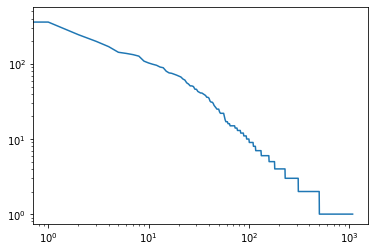

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()
#this figure shows the logarithmic frequency distribution of the words


In [13]:
import nltk

tyb_text = nltk.Text(tyb_tokenize)

tyb_Index = nltk.text.ConcordanceIndex(tyb_text)

#type(tyb_text)

#I'm now checking how the word 'agree' is embedded in context
tyb_Index.print_concordance('agree')

Displaying 11 of 11 matches:
 Person A 1:08 Yeah I know I totally agree with the practical thing because the
12 Uh huh-- Person B 2:12 --strongly agree side Person A 2:16 Yeah I I do n't k
he right to um dignity And so yeah I agree with with the idea that physician as
 laugh Person A 0:59 laugh Yeah no I agree with what you said about like normal
e with their Person A 2:55 Yeah so I agree with like having options but how wou
t too strongly but just moderately I agree with the statement is because um I'm
agree with that Person B 2:08 Yeah I agree with those points But I think like s
 strongly disagreed Did you strongly agree Person A 0:20 I agreed yeah Person B
n B 1:46 Yeah so I feel like we both agree it would be good for volunteers Pers
ay I did Person B 1:10 Yea I kind of agree with what you said that they were ju
s uh one of the reasons that I would agree not to abolish capital punishment is


#### Observation: debating whether or not we should remove the timestamps. We haven't yet learned how to analyze conversational turns and how to factor in time during/between turns/labeled events.

In [14]:
#I'm checking the context the word 'agree' appears directly before and after
tyb_text.common_contexts(['agree'])

totally_with --strongly_side i_with strongly_person both_it of_with
would_not


#### Observation: the context in which a participant expresses agreement is very important - as we can see, some people express lukewarm agreement ("kind of") and others express strong agreement ("strongly agree"), and context is needed to create a gradient/agreement score.

In [22]:
tyb_text.count('agree')

11

In [23]:
tyb_text.count('disagree')

5

In [24]:
tyb_text.count('wrong')

1

In [25]:
tyb_text.count('hate')

2

/Users/Sruti/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/Sruti/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/Sruti/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/Sruti/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/Sruti/opt/anaconda3/lib/python3.7/_collections_abc.py:841: Matplotlib

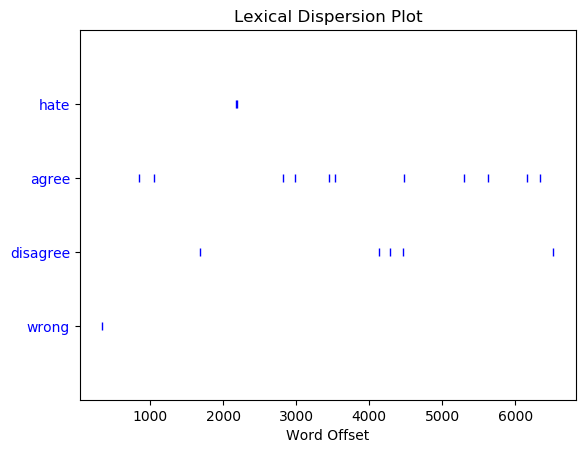

In [26]:
sns.reset_orig()
tyb_text.dispersion_plot(['hate', 'agree', 'disagree', 'wrong'])
#I will pot an edited version of this graph

#### Observation: superficially, it looks like "agree" shows up across all the transcripts more frequently than "disagree". However, we should take a closer look at all the contexts in which "agree" shows up, and keep in mind that the TYB condition primes participants to say that they agree more than in the NB condition. Should split dataset by condition and recalculate frequency

# Filtering and normalizing text

As we want to start comparing the different releases we may choose to do a bit of filtering and normalizing that will allow us to focus on what we most care about. We can first make all of the words lower case, then drop the non-word tokens. Next, we can remove some 'stop words', stem the remaining words to remove suffixes, prefixes and (in some languages) infixes, or lemmatize tokens by intelligently grouping inflected or variant forms of the same word (e.g., with a stemmer and a dictionary). 

To begin this process, we will first define a function to work over the tokenized lists, then another to add normalized tokens to a new column.

We will be using spaCy's built in stop words identifying capacity. When we run text through spaCy's language pipeline, it automatically tags it as a stop word. 

We can remove these stopwords from the analysis by fiat, but we could also take a more principled approach by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection. Alternatively, we could automatically set a cut-off by rule, such as removal of all words more frequent then the most frequent verb, or the most frequent noun (not pronoun), or some term of central interest. 

In [31]:
countsDict = {}
for word in whReleases['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('the', 179),
 ('of', 112),
 ('to', 112),
 ('and', 108),
 ('in', 64),
 ('a', 61),
 ("'s", 50),
 ('that', 41),
 ('our', 39),
 ('for', 35),
 ('on', 33),
 ('is', 33),
 ('Whitehouse', 31),
 ('Iraq', 28),
 ('Bush', 27),
 ('President', 25),
 ('troops', 21),
 ('American', 19),
 ('by', 19),
 ('Rhode', 18)]

We can look at this and pick the cutoff, often at the first noun. So we will cut all words before `'Whitehouse'`.

In [32]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Whitehouse':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

['the', 'of', 'to', 'and', 'in', 'a', "'s", 'that', 'our', 'for', 'on', 'is']

If we did have any extra words to add as stop words apart from those normally considered as stop words, we would add it to our stop words by passing it to the normalize tokens method. 

Now we can create our function to normalize the tokens

In [33]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [34]:
whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))

whReleases

,download_url,html_url,name,path,text,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Whitehouse123.txt,raw/Whitehouse/10Apr2007Whitehouse123.txt,SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...,"[SEN, WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S, ...",350,"[sen, whitehouse, share, westerly, girl, story...",224
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Whitehouse2.txt,raw/Whitehouse/10Apr2008Whitehouse2.txt,SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...,"[SEN, WHITEHOUSE, SAYS, PRESIDENT, BUSH, MUST,...",311,"[sen, whitehouse, say, president, bush, begin,...",159
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Whitehouse3.txt,raw/Whitehouse/10Apr2008Whitehouse3.txt,EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...,"[EPA, MUST, REVIEW, LEGAL, PROCESS, TO, ROOT, ...",497,"[epa, review, legal, process, root, political,...",298
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2007Whitehouse78.txt,raw/Whitehouse/10Aug2007Whitehouse78.txt,R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...,"[R.I., SENATORS, PRAISE, SEN, DENIAL, OF, LNG,...",189,"[r.i, senator, praise, sen, denial, lng, facil...",116
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Jan2008Whitehouse35.txt,raw/Whitehouse/10Jan2008Whitehouse35.txt,SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...,"[SEN, WHITEHOUSE, COMMENTS, ON, ONE, YEAR, ANN...",236,"[sen, whitehouse, comment, year, anniversary, ...",125
5,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Mar2008Whitehouse8.txt,raw/Whitehouse/10Mar2008Whitehouse8.txt,"SENS. REED, WHITEHOUSE WELCOME RHODE ISLAND ST...","[SENS, REED, WHITEHOUSE, WELCOME, RHODE, ISLAN...",334,"[sens, reed, whitehouse, welcome, rhode, islan...",198
6,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Sep2007Whitehouse72.txt,raw/Whitehouse/10Sep2007Whitehouse72.txt,REP. WHITEHOUSE ISSUES STATEMENT ON GEN. PETRA...,"[REP, WHITEHOUSE, ISSUES, STATEMENT, ON, GEN, ...",241,"[rep, whitehouse, issue, statement, gen, petra...",118
7,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Apr2007Whitehouse122.txt,raw/Whitehouse/11Apr2007Whitehouse122.txt,SEN. WHITEHOUSE URGES BUSH FOR NEW DIRECTION I...,"[SEN, WHITEHOUSE, URGES, BUSH, FOR, NEW, DIREC...",469,"[sen, whitehouse, urge, bush, new, direction, ...",249
8,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Jan2007Whitehouse161.txt,raw/Whitehouse/11Jan2007Whitehouse161.txt,"SENS. REED, WHITEHOUSE URGE PORTUGAL TO RECONS...","[SENS, REED, WHITEHOUSE, URGE, PORTUGAL, TO, R...",443,"[sens, reed, whitehouse, urge, portugal, recon...",237
9,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Mar2008Whitehouse7.txt,raw/Whitehouse/11Mar2008Whitehouse7.txt,WHITEHOUSE UNVEILS 'BUSH DEBT': $7.7 TRILLION ...,"[WHITEHOUSE, UNVEILS, BUSH, DEBT, $, 7.7, TRIL...",425,"[whitehouse, unveil, bush, debt, $, foregone, ...",242


You can see that in the final step of normalizing, we add the lemmatized form of the word. spaCy's built in lemmatizer does this (https://spacy.io/api/lemmatizer). Lemmatization can be thought of as finding the root or the base of the word after removing inflections and other variations of words. Another possible way of finding the roots of words is using NLTK's porting or stemming functionalities, but we will not be getting into them.

Now that it is cleaned we start analyzing the dataset. We can start by finding frequency distributions for the dataset. Lets start looking at all the press releases together. The [`ConditionalFreqDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) class reads in an iterable of tuples, the first element is the condition and the second the focal word. For starters, we will use word lengths as the conditions, but tags or clusters will provide more useful results.

In [35]:
#.sum() adds together the lists from each row into a single list
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))

#print the number of words
print(whcfdist.N())

1966


From this we can lookup the distributions of different word lengths

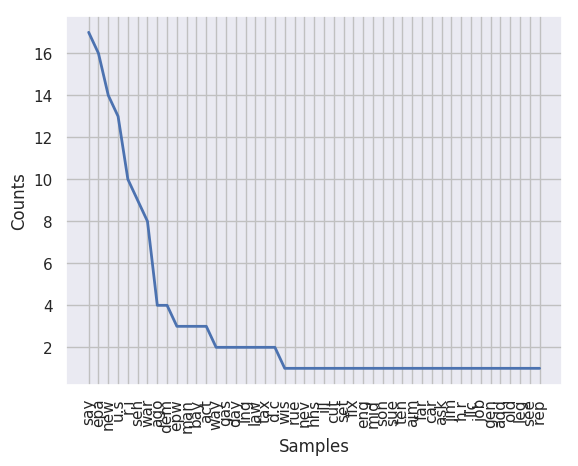

In [36]:
whcfdist[3].plot()

We can also create a Conditional Probability Distribution or [`ConditionalProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) from the `ConditionalFreqDist`. To do this, however, we need a model for the probability distribution. A simple model is [`ELEProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ELEProbDist) which gives the expected likelihood estimate for the probability distribution of the experiment used to generate the observed frequency distribution. 

In [37]:
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(whcpdist[2].max())

#And its probability
print(whcpdist[2].prob(whcpdist[2].max()))

ri
0.25


Length is one feature of a word, but there are many more important features we care about. Another critical feature is a word's role in the sentence, or its part of speech (POS). 

The method below works similarly to ```nltk.pos_text```, and can work with the conditional frequency distributions it provides.

In [38]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [39]:
whReleases['normalized_tokens_POS'] = [spacy_pos(t) for t in whReleases['text']]

This gives us a new column with the part of speech as a short initialism and the word in a tuple, exactly how the `nltk.ConditionalFreqDist()` function wants them. We can now construct another conditional frequency distribution.

In [40]:
whcfdist_WordtoPOS = nltk.ConditionalFreqDist(whReleases['normalized_tokens_POS'].sum())
list(whcfdist_WordtoPOS.items())[:10]

[('academic', FreqDist({'JJ': 3, 'NNP': 1})),
 ('risks', FreqDist({'VBZ': 1, 'NNS': 1})),
 ('transplants', FreqDist({'NNS': 1})),
 ('class', FreqDist({'NN': 2})),
 ('research', FreqDist({'NN': 8, 'NNP': 1})),
 ('their', FreqDist({'PRP$': 15})),
 ('reid', FreqDist({'NNP': 1})),
 ('acknowledged', FreqDist({'VBD': 1})),
 ('urge', FreqDist({'VBP': 1})),
 ('august', FreqDist({'NNP': 1}))]

This gives the frequency of each word as each part of speech...which can be uninformative and boring. What we want is the converse; the frequency of each part of speech for each word.

In [41]:
whcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in whReleases['normalized_tokens_POS'].sum())

We can now identify and collect all of the superlative adjectives

In [42]:
whcfdist_POStoWord['JJ']

FreqDist({'american': 17, 'new': 10, 'portuguese': 9, 'political': 8, 'federal': 6, 'clear': 5, 'fiscal': 5, 'potential': 5, 'last': 4, 'several': 4, ...})

Or look at the most common nouns

In [43]:
whcfdist_POStoWord['NN'].most_common(5)

[('today', 15),
 ('year', 12),
 ('administration', 11),
 ('consulate', 10),
 ('stem', 10)]

Or plot the base form verbs against their number of occurrences

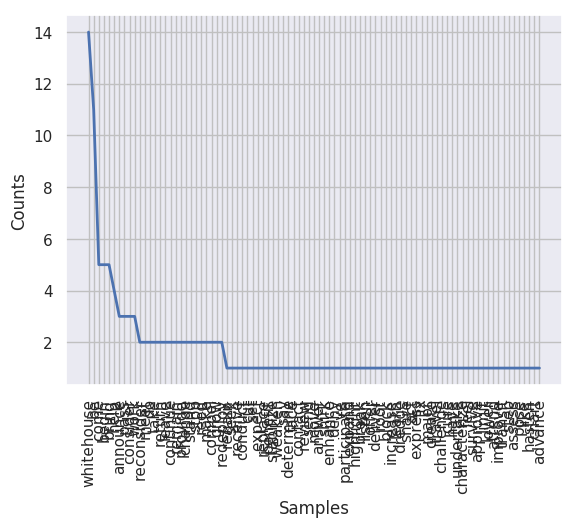

In [44]:
whcfdist_POStoWord['VB'].plot()

We can then do a similar analysis of the word probabilities

In [45]:
whcpdist_POStoWord = nltk.ConditionalProbDist(whcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(whcpdist_POStoWord['NN'].max())

#And its probability
print(whcpdist_POStoWord['NN'].prob(whcpdist_POStoWord['NN'].max()))

today
0.020195439739413682


We can even create a...wait for it...*WORD CLOUD* or Wordl to gaze at and draw mystical, approximate inferences about important nouns and verbs in our corpus:

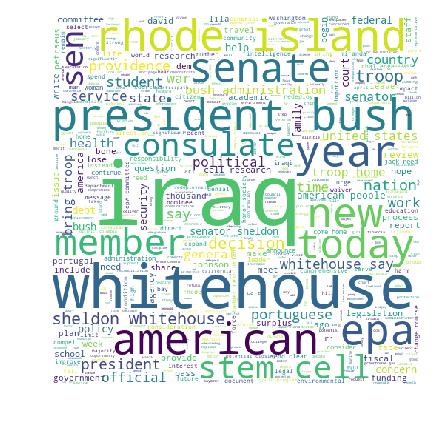

In [46]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(whReleases['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("whitehouse_word_cloud.pdf", format = 'pdf')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</span>

In [15]:
tyb_transcripts

'5\nPerson A  0:01  \nOkay, so uh, I guess they said we should start? \n\nPerson B  0:03  \nYea, we should start\n\nPerson A  0:05  \nSo uh they said that this is a topic we disagreed on. So I\'m guessing you said that it shouldn\'t be abolished? \n\nPerson B  0:10  \nUm, yeah.\n\nPerson A  0:10  \nUm I guess I\'d like to hear you talk about it\n\nPerson B  0:18  \nI actually didn\'t look much into the legal system here, but for death penalty, I think like, if..I think if someone committed to a really serious crime such as umm very like, like murdering people and like not being regretful about that and then um like continuously doing a lot of things that will harm the security of the society and also the people around them. I don\'t think there is any reason why this person could continue to live in this society,\n\nPerson A  1:01  \nYeah, like definitely, like, I definitely see what you mean what the reason I personally am against the death penalty isn\'t because I don\'t think some p

In [16]:
#filter
countsDict = {}
for word in tyb_tokenize: 
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:50]

[('like', 415),
 ('I', 361),
 ('Person', 195),
 ('that', 168),
 ('the', 143),
 ('a', 141),
 ('it', 134),
 ('you', 129),
 ('to', 126),
 ('A', 104),
 ('of', 103),
 ('think', 99),
 ("n't", 96),
 ('B', 91),
 ('do', 88),
 ('and', 80),
 ("'s", 80),
 ('in', 74),
 ('is', 69),
 ('just', 66),
 ('be', 63),
 ('people', 61),
 ('um', 57),
 ('they', 52),
 ('know', 51),
 ('if', 49),
 ('not', 46),
 ('have', 46),
 ('so', 43),
 ('Yeah', 43),
 ('would', 43),
 ('this', 41),
 ('but', 41),
 ('there', 40),
 ("'re", 40),
 ('uh', 39),
 ('should', 39),
 ('really', 38),
 ('what', 38),
 ('are', 35),
 ('about', 32),
 ('because', 32),
 ('or', 32),
 ('on', 31),
 ('So', 30),
 ('for', 30),
 ('And', 29),
 ('with', 29),
 ('we', 28),
 ('yeah', 28)]

In [311]:
stop_words_freq = []
for word, count in word_counts:
    if word == 'B':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq=['if', 'Person', 'person','the', 'that', 'a']
stop_words_freq

['if', 'Person', 'person', 'the', 'that', 'a']

#### Rather than choose all the words before the most frequent noun, we chose our own stop_words. Chose "person" because that's how we labelled participants (person A, person B).

In [312]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list])

    doc = nlp(word_list.lower())
    
        # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [313]:
tyb_normalized = normalizeTokens(tyb_transcripts,stop_words_freq)
tyb_normalized

['0:01',
 'okay',
 'uh',
 'guess',
 'say',
 'start',
 'b',
 '0:03',
 'yea',
 'start',
 '0:05',
 'uh',
 'say',
 'topic',
 'disagree',
 'guess',
 'say',
 'abolish',
 'b',
 '0:10',
 'um',
 'yeah',
 '0:10',
 'um',
 'guess',
 'like',
 'hear',
 'talk',
 'b',
 '0:18',
 'actually',
 'look',
 'legal',
 'system',
 'death',
 'penalty',
 'think',
 'like',
 'think',
 'commit',
 'crime',
 'umm',
 'like',
 'like',
 'murder',
 'people',
 'like',
 'regretful',
 'um',
 'like',
 'continuously',
 'lot',
 'thing',
 'harm',
 'security',
 'society',
 'people',
 'think',
 'reason',
 'continue',
 'live',
 'society',
 '1:01',
 'yeah',
 'like',
 'definitely',
 'like',
 'definitely',
 'mean',
 'reason',
 'personally',
 'death',
 'penalty',
 'think',
 'people',
 'remove',
 'society',
 'like',
 'like',
 'know',
 'like',
 'terrorist',
 'know',
 'people',
 'indiscriminately',
 'like',
 'know',
 'think',
 'remove',
 'society',
 'time',
 'know',
 'term',
 'like',
 'implementation',
 'lot',
 'time',
 'like',
 'like',
 '

In [20]:
#.sum() adds together the lists from each row into a single list
tybfreq = nltk.ConditionalFreqDist(((len(w), w) for w in tyb_normalized))
tybfreq
print(tybfreq.N())

2782


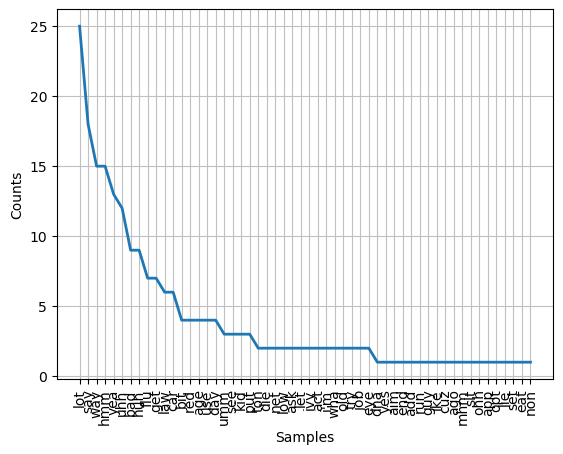

In [34]:
#plots distribution of word length in the transcripts
tybfreq[3].plot()


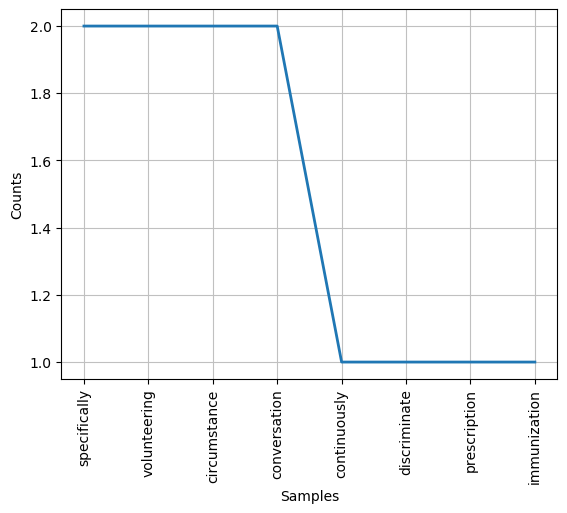

In [35]:
tybfreq[12].plot() #words that have 12 letters

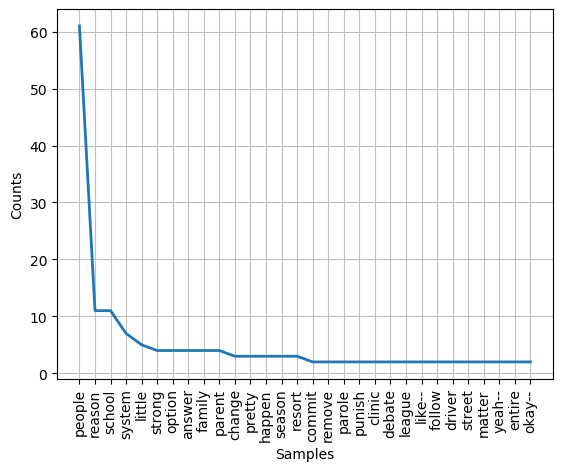

In [36]:
tybfreq[6].plot(30)


In [21]:
tybpdist = nltk.ConditionalProbDist(tybfreq, nltk.ELEProbDist)
#print the most common 2 letter word
print(tybpdist[2].max())
#And its probability
print(tybpdist[2].prob(tybpdist[2].max()))



um
0.38345864661654133


In [90]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags
#used this again later for dataframe format

In [23]:
tybpos = spacy_pos(tyb_transcripts)
tybpos

[('5', 'LS'),
 ('\n', '_SP'),
 ('person', 'NN'),
 ('a', 'DT'),
 (' ', '_SP'),
 ('0:01', 'CD'),
 (' \n', '_SP'),
 ('okay', 'UH'),
 (',', ','),
 ('so', 'RB'),
 ('uh', 'UH'),
 (',', ','),
 ('i', 'PRP'),
 ('guess', 'VBP'),
 ('they', 'PRP'),
 ('said', 'VBD'),
 ('we', 'PRP'),
 ('should', 'MD'),
 ('start', 'VB'),
 ('?', '.'),
 ('\n\n', '_SP'),
 ('person', 'NN'),
 ('b', 'NNP'),
 (' ', '_SP'),
 ('0:03', 'CD'),
 (' \n', '_SP'),
 ('yea', 'NN'),
 (',', ','),
 ('we', 'PRP'),
 ('should', 'MD'),
 ('start', 'VB'),
 ('\n\n', '_SP'),
 ('person', 'NN'),
 ('a', 'DT'),
 (' ', '_SP'),
 ('0:05', 'CD'),
 (' \n', '_SP'),
 ('so', 'RB'),
 ('uh', 'UH'),
 ('they', 'PRP'),
 ('said', 'VBD'),
 ('that', 'IN'),
 ('this', 'DT'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('topic', 'NN'),
 ('we', 'PRP'),
 ('disagreed', 'VBD'),
 ('on', 'RP'),
 ('.', '.'),
 ('so', 'RB'),
 ('i', 'PRP'),
 ("'m", 'VBP'),
 ('guessing', 'VBG'),
 ('you', 'PRP'),
 ('said', 'VBD'),
 ('that', 'IN'),
 ('it', 'PRP'),
 ('should', 'MD'),
 ("n't", 'RB'),
 ('be', 'V

In [315]:
tybdistpos = nltk.ConditionalFreqDist(tybpos) #boring, not what we actually care about
list(tybdistpos.items())[:10]

[('5', FreqDist({'LS': 1})),
 ('\n', FreqDist({'_SP': 5})),
 ('person', FreqDist({'NN': 200})),
 ('a', FreqDist({'DT': 245})),
 (' ', FreqDist({'_SP': 171})),
 ('0:01', FreqDist({'CD': 1})),
 (' \n', FreqDist({'_SP': 164})),
 ('okay', FreqDist({'UH': 14, 'JJ': 1})),
 (',', FreqDist({',': 523})),
 ('so', FreqDist({'RB': 60, 'IN': 9, 'CC': 4}))]

In [316]:
tybfdistpos_to_word = nltk.ConditionalFreqDist((p, w) for w, p in tybpos)
tybfdistpos_to_word

<ConditionalFreqDist with 43 conditions>

In [26]:
tybfdistpos_to_word['JJ']  

FreqDist({'right': 7, 'moral': 6, 'sure': 6, 'other': 6, 'uhh': 6, 'good': 6, 'different': 6, 'legal': 5, 'same': 5, 'able': 5, ...})

#### Superlative adjectives ^^, though I'm not sure that all of the listed words are actually adjectives. I wonder why it counted "uhh" as one.

In [319]:
tybfdistpos_to_word['NN'].most_common(3)

[('person', 200), ('lot', 25), ('something', 25)]

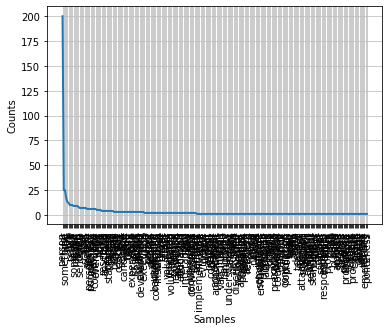

In [321]:
tybfdistpos_to_word['NN'].plot() #conditional distribution (nouns)

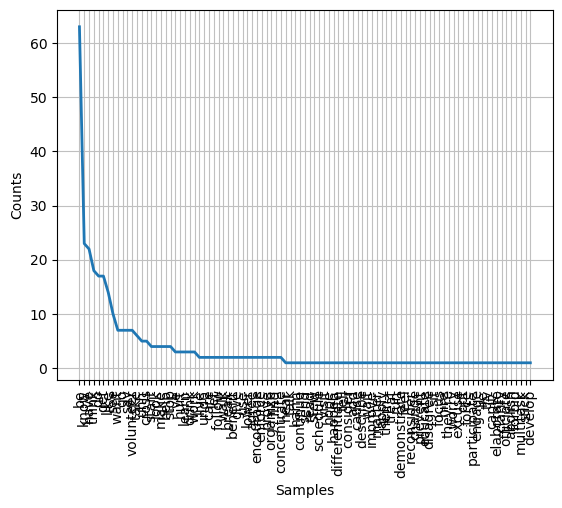

In [44]:
tybfdistpos_to_word['VB'].plot() #Conditional frequency distribution (verbs)

In [314]:
tybpdistpos_to_word = nltk.ConditionalProbDist(tybfdistpos_to_word, nltk.ELEProbDist)

#print the most common nouns
print(tybpdistpos_to_word['NN'].max())

#And its probability
print(tybpdistpos_to_word['NN'].prob(tybpdistpos_to_word['NN'].max()))

person
0.21284501061571126


#### I'm not sure why it's still counting "person"; I included this word as a stop word. However, we can see in the output from tybfdistpos_to_word['NN'].most_common(5) that "lot" is the second most common noun.

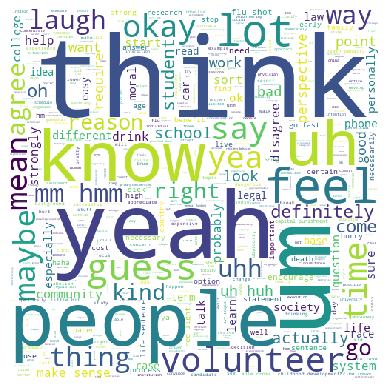

In [46]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(tyb_normalized))
plt.imshow(wc)
plt.axis("off")
plt.savefig("tyb_word_cloud.pdf", format = 'pdf')


#### This shows us that "think" and "yeah" are some of the most frequently appearing words in the corpus/transcripts. It's interesting that "person" doesn't show up here, even though it's the most common noun- which tells me that it registered as a stop word, so I wonder why it was showing up still in the conditional plot. We can see that the most commonly appearing words are filler-words, like "um", and maybe there's a way to further classify filler-words (ex., "hmm" versus "mhm" versus "mmm"). Some might signal agreement, and that's important to capture (we're interested in how agreement across the TYB and NB conditions. It's also interesting that mitigating words like "maybe" and "guess" show up more frequently than more definitive-sounding words like "definitely", though we'll have to look at the context surrounding those words before making any inferences.

## Davies Corpora

Now that we have our basic cleaning down, we can arrange our Davies Corpora. Let us try this with the movies corpora we have already loaded.

We'll use a smaller corpus of a 1000 movies for this demonstration.

In [47]:
zfile = zipfile.ZipFile(corpus_name + "/sources_movies.zip")
source = []

In [48]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [49]:
source[0:20]

[b'textID\tfileID\t#words\tgenre\tyear\tlanguage(s)\tcountry\timdb\ttitle\r\n',
 b'-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\t-----\r\n',
 b'\r\n',
 b'290635\t3547424\t4722\tShort, Musical\t1930\tUK\tEnglish\t0290635\tGoodbye to All That\r\n',
 b'21165\t6332374\t10220\tCrime, Mystery, Thriller\t1930\tUK\tEnglish\t0021165\tMurder!\r\n',
 b'21191\t6013789\t5281\tDrama, Romance\t1930\tUSA\tEnglish\t0021191\tA Notorious Affair\r\n',
 b'20620\t3660608\t6724\tBiography, Drama, History\t1930\tUSA\tEnglish\t0020620\tAbraham Lincoln\r\n',
 b'20629\t60053\t9552\tDrama, War\t1930\tUSA\tEnglish, French, German, Latin\t0020629\tAll Quiet on the Western Front\r\n',
 b'20640\t6850720\t13862\tComedy, Musical\t1930\tUSA\tEnglish\t0020640\tAnimal Crackers\r\n',
 b'20641\t176501\t11140\tDrama, Romance\t1930\tUSA\tEnglish\t0020641\tAnna Christie\r\n',
 b'20643\t3603861\t1748\tComedy, Short\t1930\tUSA\tEnglish\t0020643\tAnother Fine Mess\r\n',
 b'20670\t4159455\t6966\tComedy, Musical\t1930\tUS

It looks dirty because the file is encoded as bytes, but we can certainly see the information there. The file id is also present in the original raw text data: as the first "word". Look back at the normalized/tokenized words to confirm that. We're going to use this to create a dataframe with: Fileid, movie name, genre, year, and country.

It is advised that you run a similar check of the source file before you do other extraction.

First, let us create a dictionary mapping file-id to all the text. Each movie will be mapped to a list of the tokenized words.

In this example, I only use it to load 100 movies. You can comment this out or increase/decrease the number as you see fit.

In [50]:
movie_texts = {}

In [51]:
for files in movie_raw:
    if len(movie_texts) > 100:
        break
    movies = clean_raw_text(movie_raw[files][1:])
    for movie in movies:
        txts = lucem_illud_2020.word_tokenize(movie)
        try:
            movie_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

In [52]:
import pandas as pd

In [53]:
movie_df = pd.DataFrame(columns=["Movie Name", "Genre", "Year", "Country", "Tokenized Texts"])

In [54]:
for movie in source[3:]:
    try:
        tid, fileid, total_words, genre, year, lang, country, imdb, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    try:
        movie_df.loc[fileid.strip()] = [title.strip(), genre.strip(), year.strip(), country.strip(), movie_texts[fileid.strip()]]
    except KeyError:
        continue

In [55]:
movie_df.head()

,Movie Name,Genre,Year,Country,Tokenized Texts
3147360,The Devil's Parade,Short,1930,English,"[Good, luck, Hi, Uh, I, have, an, appointment,..."
3276830,Smart Money,"Crime, Drama",1931,English,"[Aces, Fine, Come, on, ace, Ah, Thank, goodnes..."
6750675,The Mad Genius,"Drama, Horror, Romance",1931,English,"[Not, so, high, on, your, left, string, Faster..."
6837507,"Hey, Pop!","Short, Comedy",1932,English,"[One, glass, of, milk, One, pork, sandwich, to..."
4194247,One Hour with You,"Comedy, Musical, Romance",1932,"English, French","[Now, listen, men, Spring, is, here, and, spri..."


# Part-of-Speech (POS) tagging

In POS tagging, we classify each word by its semantic role in a sentence. We will be using the in-built spaCy pos-tagging.

https://spacy.io/usage/linguistic-features

|#. |Tag |Description |
|---|----|------------|
|1.	|CC	|Coordinating conjunction
|2.	|CD	|Cardinal number
|3.	|DT	|Determiner
|4.	|EX	|Existential there
|5.	|FW	|Foreign word
|6.	|IN	|Preposition or subordinating conjunction
|7.	|JJ	|Adjective
|8.	|JJR|	Adjective, comparative
|9.	|JJS|	Adjective, superlative
|10.|	LS	|List item marker
|11.|	MD	|Modal
|12.|	NN	|Noun, singular or mass
|13.|	NNS	|Noun, plural
|14.|	NNP	|Proper noun, singular
|15.|	NNPS|	Proper noun, plural
|16.|	PDT	|Predeterminer
|17.|	POS	|Possessive ending
|18.|	PRP	|Personal pronoun
|19.|	PRP\$|	Possessive pronoun
|20.|	RB	|Adverb
|21.|	RBR	|Adverb, comparative
|22.|	RBS	|Adverb, superlative
|23.|	RP	|Particle
|24.|	SYM	|Symbol
|25.|	TO	|to
|26.|	UH	|Interjection
|27.|	VB	|Verb, base form
|28.|	VBD	|Verb, past tense
|29.|	VBG	|Verb, gerund or present participle
|30.|	VBN	|Verb, past participle
|31.|	VBP	|Verb, non-3rd person singular present
|32.|	VBZ	|Verb, 3rd person singular present
|33.|	WDT	|Wh-determiner
|34.|	WP	|Wh-pronoun
|35.|	WP$	|Possessive wh-pronoun
|36.|	WRB	|Wh-adverb

spaCy pos-tags word as we run it through the english language model. A small example:

In [56]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")


In [57]:
for token in sent:
    print(token.text, token.pos_, token.tag_)

Tom PROPN NNP
went VERB VBD
to ADP IN
IKEA PROPN NNP
to PART TO
get AUX VB
some DET DT
of ADP IN
those DET DT
delicious ADJ JJ
Swedish ADJ JJ
meatballs NOUN NNS
. PUNCT .


This looks quite good. Now we will try POS tagging with a somewhat larger corpus. We consider a few of the top posts from the reddit data we used last week.

In [58]:
redditDF = pandas.read_csv('../data/reddit.csv')

Grabbing the 10 highest scoring posts and tokenizing the sentences. Once again, notice that we aren't going to do any kind of stemming this week (although *semantic* normalization may be performed where we translate synonyms into the same focal word). Here, we will use sentences tokenized by spaCy. Like before, these methods can also be found in lucem_illud.



In [59]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [60]:
redditTopScores = redditDF.sort_values('score')[-10:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores

,Unnamed: 0,author,over_18,score,subreddit,text,title,url,sentences
9,8,brenkelieshere,False,9448,Tales From Tech Support,"Last year, Help Desk got a call from a user co...",How to fix a laptop that won't boot in under a...,https://www.reddit.com/r/talesfromtechsupport/...,"[[Last, year, Help, Desk, got, a, call, from, ..."
8,7,Bombadils,False,10528,Tales From Tech Support,First post in quite some time! I work at a loc...,"OK, now the password is 'D35p41r'",https://www.reddit.com/r/talesfromtechsupport/...,"[[First, post, in, quite, some, time], [I, wor..."
7,1200,whenlifegivesyoushit,False,11003,Relationships,[Original Post](https://www.reddit.com/r/relat...,[UPDATE]My [26 F] with my husband [29 M] 1 yea...,https://www.reddit.com/r/relationships/comment...,"[[Original, Post](https://www.reddit.com, r, r..."
6,6,sfsdfd,False,11295,Tales From Tech Support,I witnessed this astounding IT meltdown around...,"Company-wide email + 30,000 employees + auto-r...",https://www.reddit.com/r/talesfromtechsupport/...,"[[I, witnessed, this, astounding, IT, meltdown..."
5,5,Raitaro,False,12372,Tales From Tech Support,I work Helpdesk for a retail store chain in th...,I'm pretty sure I knocked a user out from near...,https://www.reddit.com/r/talesfromtechsupport/...,"[[I, work, Helpdesk, for, a, retail, store, ch..."
4,4,goldie-gold,False,12650,Tales From Tech Support,"This just happened... So, I had a laptop syst...",Engineer is doing drugs!! No. No they aren't.,https://www.reddit.com/r/talesfromtechsupport/...,"[[This, just, happened], [So, I, had, a, lapto..."
3,3,TheDroolinFool,False,13152,Tales From Tech Support,Another tale from the out of hours IT desk... ...,"""I need you to fix Google Bing immediately!""",https://www.reddit.com/r/talesfromtechsupport/...,"[[Another, tale, from, the, out, of, hours], [..."
2,2,Clickity_clickity,False,13404,Tales From Tech Support,[Part 1](http://www.reddit.com/r/talesfromtech...,"Jack, the Worst End User, Part 4",https://www.reddit.com/r/talesfromtechsupport/...,"[[Part, 1](http://www.reddit.com, r, talesfrom..."
1,1,SECGaz,False,13724,Tales From Tech Support,"> $Me - Hello, IT. > $Usr - Hi, I am still ...","Hi, I am still off sick but I am not.",https://www.reddit.com/r/talesfromtechsupport/...,"[[>], [$, Me], [Hello, IT], [>, $], [Usr, Hi, ..."
0,0,guitarsdontdance,False,14089,Tales From Tech Support,So my story starts on what was a normal day ta...,"""Don't bother sending a tech, I'll be dead by ...",https://www.reddit.com/r/talesfromtechsupport/...,"[[So, my, story, starts, on, what, was, a, nor..."


In [61]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [62]:
redditTopScores['POS_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_pos(x))

In [63]:
redditTopScores['POS_sents']

9    [[(Last, JJ), (year, NN), (Help, NNP), (Desk, ...
8    [[(First, JJ), (post, NN), (in, IN), (quite, P...
7    [[(Original, NNP), (Post](https://www.reddit.c...
6    [[(I, PRP), (witnessed, VBD), (this, DT), (ast...
5    [[(I, PRP), (work, VBP), (Helpdesk, NNP), (for...
4    [[(This, DT), (just, RB), (happened, VBD)], [(...
3    [[(Another, DT), (tale, NN), (from, IN), (the,...
2    [[(Part, NN), (1](http://www.reddit.com, CD), ...
1    [[(>, XX)], [($, $)], [(Me, PRP)], [(Hello, UH...
0    [[(So, RB), (my, PRP$), (story, NN), (starts, ...
Name: POS_sents, dtype: object

And count the number of `NN` (nouns)

In [64]:
countTarget = 'NN'
targetCounts = {}
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('password', 21),
 ('m', 21),
 ('time', 14),
 ('computer', 13),
 ('lot', 12),
 ('email', 11),
 ('life', 11),
 ('system', 10),
 ('Genius', 9),
 ('message', 9),
 ('day', 9),
 ('laptop', 9),
 ('auto', 9),
 ('today', 8),
 ('part', 8),
 ('story', 8),
 ('call', 8),
 ('office', 8),
 ('user', 7),
 ('something', 7)]

What about the adjectives that modify the word, "computer"?

In [65]:
NTarget = 'JJ'
Word = 'computer'
NResults = set()
for entry in redditTopScores['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'unrestricted', 'own'}


## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, perform POS tagging on a meaningful (but modest) subset of a corpus associated with your final project. Examine the list of words associated with at least three different parts of speech. Consider conditional associations (e.g., adjectives associated with nouns or adverbs with verbs of interest). What do these distributions suggest about your corpus?

#### For the first two exercises, I used transcript data directly from the TYB text file. Now, I'm using the TYB data converted to dataframe form (df_con). The information is split by participant (A vs B) and condition (thank you because, TYB- and no becuase, NB). The text transcript data is in the conversation_txt column, in the same format as the original text file (except that some stop words, like 'person', were already removed). I'll be working with this dataframe for the remainder of the assignment. I'm going to update the dataframe (tokenizing and normalizing and performing counts first).

In [81]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences #Do I actually need this? Our text's already split into sentences

In [85]:
df_con #dataframe with conversation text, condition ('no because' or 'thank you because'), and split by
#participant A vs. B (participant A initiated the conversation and the "no because" or "thank you because" part)

,condition,conversation_txt,con_txt_A,con_txt_B
0,NB,"Okay, so uh, I guess they said we should start...","Okay, so uh, I guess they said we should start...","Yea, we should start Um, yeah. I actually didn..."
1,TYB,"So I don't really I think I said--yes, everyon...","So I don't really I think I said--yes, everyon...",I-I think put something that's below five.. Th...
2,NB,"Uh, so, uh I-I actually uh read a lot about th...",Ok and so what does the law say? Does it say l...,"Uh, so, uh I-I actually uh read a lot about th..."
3,TYB,Okay so you--What's your opinion on this? I st...,Okay so you--What's your opinion on this? Oh w...,I strongly disagree with this I think you shou...
4,TYB,"I'm good whenever you are Okay, let's start, y...","Okay, let's start, yea [laugh] Yeah, so um I t...","I'm good whenever you are So I guess like, wha..."
5,TYB,I just strongly believe in the right to um {{}...,I like what you said about like the right to. ...,I just strongly believe in the right to um {{}...
6,NB,"Yea, so so so. What do you--what do you person...","I think that the US, I answered that the US sh...","Yea, so so so. What do you--what do you person..."
7,NB,"Okay, um, so I put a four. I like very minorly...",I disagree. I put I put a 10 for this. And I...,"Okay, um, so I put a four. I like very minorly..."
8,TYB,"No. Yeah, that makes sense. And I, yeah, I app...","No. Yeah, that makes sense. And I, yeah, I app...",What do you know about herd immunity? Yeah.
9,TYB,"Oh, I think I strongly disagreed. Did you stro...","I agreed, yeah. Yeah. I definitely get what y...","Oh, I think I strongly disagreed. Did you stro..."


In [86]:
tyb_transcript_split = df_con['conversation_txt'].sum()
tyb_transcript_split #should be functionally the same as the txt file composite transcript I was using earlier

'Okay, so uh, I guess they said we should start?  Yea, we should start So uh they said that this is a topic we disagreed on. So I\'m guessing you said that it shouldn\'t be abolished?  Um, yeah. Um I guess I\'d like to hear you talk about it I actually didn\'t look much into the legal system here, but for death penalty, I think like, if..I think if someone committed to a really serious crime such as umm very like, like murdering people and like not being regretful about that and then um like continuously doing a lot of things that will harm the security of the society and also the people around them. I don\'t think there is any reason why this person could continue to live in this society, Yeah, like definitely, like, I definitely see what you mean what the reason I personally am against the death penalty isn\'t because I don\'t think some people should be from removed society because if you have like someone who\'s like, I don\'t know, like a terrorist who, who knows people indiscrimi

In [87]:
df_con['tokenized_text'] = df_con['conversation_txt'].apply(lambda x: word_tokenize(x))
df_con

,condition,conversation_txt,con_txt_A,con_txt_B,tokenized_text
0,NB,"Okay, so uh, I guess they said we should start...","Okay, so uh, I guess they said we should start...","Yea, we should start Um, yeah. I actually didn...","[Okay, so, uh, I, guess, they, said, we, shoul..."
1,TYB,"So I don't really I think I said--yes, everyon...","So I don't really I think I said--yes, everyon...",I-I think put something that's below five.. Th...,"[So, I, do, n't, really, I, think, I, said, ye..."
2,NB,"Uh, so, uh I-I actually uh read a lot about th...",Ok and so what does the law say? Does it say l...,"Uh, so, uh I-I actually uh read a lot about th...","[Uh, so, uh, I, I, actually, uh, read, a, lot,..."
3,TYB,Okay so you--What's your opinion on this? I st...,Okay so you--What's your opinion on this? Oh w...,I strongly disagree with this I think you shou...,"[Okay, so, you, What, 's, your, opinion, on, t..."
4,TYB,"I'm good whenever you are Okay, let's start, y...","Okay, let's start, yea [laugh] Yeah, so um I t...","I'm good whenever you are So I guess like, wha...","[I, 'm, good, whenever, you, are, Okay, let, '..."
5,TYB,I just strongly believe in the right to um {{}...,I like what you said about like the right to. ...,I just strongly believe in the right to um {{}...,"[I, just, strongly, believe, in, the, right, t..."
6,NB,"Yea, so so so. What do you--what do you person...","I think that the US, I answered that the US sh...","Yea, so so so. What do you--what do you person...","[Yea, so, so, so, What, do, you, what, do, you..."
7,NB,"Okay, um, so I put a four. I like very minorly...",I disagree. I put I put a 10 for this. And I...,"Okay, um, so I put a four. I like very minorly...","[Okay, um, so, I, put, a, four, I, like, very,..."
8,TYB,"No. Yeah, that makes sense. And I, yeah, I app...","No. Yeah, that makes sense. And I, yeah, I app...",What do you know about herd immunity? Yeah.,"[No, Yeah, that, makes, sense, And, I, yeah, I..."
9,TYB,"Oh, I think I strongly disagreed. Did you stro...","I agreed, yeah. Yeah. I definitely get what y...","Oh, I think I strongly disagreed. Did you stro...","[Oh, I, think, I, strongly, disagreed, Did, yo..."


In [88]:
df_con['word_counts'] = df_con['tokenized_text'].apply(lambda x: len(x))
df_con['word_counts']

0     592
1     393
2     348
3     550
4     230
5     654
6     510
7     374
8     229
9     507
10    418
11    271
Name: word_counts, dtype: int64

In [89]:
df_con['normalized_tokens'] = df_con['tokenized_text'].apply(lambda x: normalizeTokens(x))

df_con['normalized_tokens_count'] = df_con['normalized_tokens'].apply(lambda x: len(x))

df_con

,condition,conversation_txt,con_txt_A,con_txt_B,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count
0,NB,"Okay, so uh, I guess they said we should start...","Okay, so uh, I guess they said we should start...","Yea, we should start Um, yeah. I actually didn...","[Okay, so, uh, I, guess, they, said, we, shoul...",592,"[okay, uh, guess, say, start, yea, start, uh, ...",237
1,TYB,"So I don't really I think I said--yes, everyon...","So I don't really I think I said--yes, everyon...",I-I think put something that's below five.. Th...,"[So, I, do, n't, really, I, think, I, said, ye...",393,"[think, say, yes, think, oh, okay, uhhm, think...",144
2,NB,"Uh, so, uh I-I actually uh read a lot about th...",Ok and so what does the law say? Does it say l...,"Uh, so, uh I-I actually uh read a lot about th...","[Uh, so, uh, I, I, actually, uh, read, a, lot,...",348,"[uh, uh, actually, uh, read, lot, topic, uh, u...",151
3,TYB,Okay so you--What's your opinion on this? I st...,Okay so you--What's your opinion on this? Oh w...,I strongly disagree with this I think you shou...,"[Okay, so, you, What, 's, your, opinion, on, t...",550,"[okay, opinion, strongly, disagree, oh, wow--,...",179
4,TYB,"I'm good whenever you are Okay, let's start, y...","Okay, let's start, yea [laugh] Yeah, so um I t...","I'm good whenever you are So I guess like, wha...","[I, 'm, good, whenever, you, are, Okay, let, '...",230,"[m, good, okay, let, start, yea, laugh, guess,...",106
5,TYB,I just strongly believe in the right to um {{}...,I like what you said about like the right to. ...,I just strongly believe in the right to um {{}...,"[I, just, strongly, believe, in, the, right, t...",654,"[strongly, believe, right, um, dignity, yeah, ...",269
6,NB,"Yea, so so so. What do you--what do you person...","I think that the US, I answered that the US sh...","Yea, so so so. What do you--what do you person...","[Yea, so, so, so, What, do, you, what, do, you...",510,"[yea, personally, think, think, answer, lower,...",211
7,NB,"Okay, um, so I put a four. I like very minorly...",I disagree. I put I put a 10 for this. And I...,"Okay, um, so I put a four. I like very minorly...","[Okay, um, so, I, put, a, four, I, like, very,...",374,"[okay, um, like, minorly, disagree, um, ok, de...",161
8,TYB,"No. Yeah, that makes sense. And I, yeah, I app...","No. Yeah, that makes sense. And I, yeah, I app...",What do you know about herd immunity? Yeah.,"[No, Yeah, that, makes, sense, And, I, yeah, I...",229,"[yeah, make, sense, yeah, appreciate, sentimen...",99
9,TYB,"Oh, I think I strongly disagreed. Did you stro...","I agreed, yeah. Yeah. I definitely get what y...","Oh, I think I strongly disagreed. Did you stro...","[Oh, I, think, I, strongly, disagreed, Did, yo...",507,"[oh, think, strongly, disagree, strongly, agre...",213


In [92]:
df_con['normalized_tokens_POS'] = [spacy_pos(t) for t in df_con['conversation_txt']]
df_con
#Already did the necessary analyses with this in exercises 1-2, but converting everything
#to dataframe form for ease of access for the forthcoming exercises

,condition,conversation_txt,con_txt_A,con_txt_B,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count,normalized_tokens_POS
0,NB,"Okay, so uh, I guess they said we should start...","Okay, so uh, I guess they said we should start...","Yea, we should start Um, yeah. I actually didn...","[Okay, so, uh, I, guess, they, said, we, shoul...",592,"[okay, uh, guess, say, start, yea, start, uh, ...",237,"[(okay, UH), (,, ,), (so, RB), (uh, UH), (,, ,..."
1,TYB,"So I don't really I think I said--yes, everyon...","So I don't really I think I said--yes, everyon...",I-I think put something that's below five.. Th...,"[So, I, do, n't, really, I, think, I, said, ye...",393,"[think, say, yes, think, oh, okay, uhhm, think...",144,"[(so, CC), (i, PRP), (do, VBP), (n't, RB), (re..."
2,NB,"Uh, so, uh I-I actually uh read a lot about th...",Ok and so what does the law say? Does it say l...,"Uh, so, uh I-I actually uh read a lot about th...","[Uh, so, uh, I, I, actually, uh, read, a, lot,...",348,"[uh, uh, actually, uh, read, lot, topic, uh, u...",151,"[(uh, UH), (,, ,), (so, CC), (,, ,), (uh, UH),..."
3,TYB,Okay so you--What's your opinion on this? I st...,Okay so you--What's your opinion on this? Oh w...,I strongly disagree with this I think you shou...,"[Okay, so, you, What, 's, your, opinion, on, t...",550,"[okay, opinion, strongly, disagree, oh, wow--,...",179,"[(okay, UH), (so, IN), (you, PRP), (--, :), (w..."
4,TYB,"I'm good whenever you are Okay, let's start, y...","Okay, let's start, yea [laugh] Yeah, so um I t...","I'm good whenever you are So I guess like, wha...","[I, 'm, good, whenever, you, are, Okay, let, '...",230,"[m, good, okay, let, start, yea, laugh, guess,...",106,"[(i, PRP), ('m, VBP), (good, JJ), (whenever, W..."
5,TYB,I just strongly believe in the right to um {{}...,I like what you said about like the right to. ...,I just strongly believe in the right to um {{}...,"[I, just, strongly, believe, in, the, right, t...",654,"[strongly, believe, right, um, dignity, yeah, ...",269,"[(i, PRP), (just, RB), (strongly, RB), (believ..."
6,NB,"Yea, so so so. What do you--what do you person...","I think that the US, I answered that the US sh...","Yea, so so so. What do you--what do you person...","[Yea, so, so, so, What, do, you, what, do, you...",510,"[yea, personally, think, think, answer, lower,...",211,"[(yea, UH), (,, ,), (so, RB), (so, RB), (so, R..."
7,NB,"Okay, um, so I put a four. I like very minorly...",I disagree. I put I put a 10 for this. And I...,"Okay, um, so I put a four. I like very minorly...","[Okay, um, so, I, put, a, four, I, like, very,...",374,"[okay, um, like, minorly, disagree, um, ok, de...",161,"[(okay, UH), (,, ,), (um, UH), (,, ,), (so, RB..."
8,TYB,"No. Yeah, that makes sense. And I, yeah, I app...","No. Yeah, that makes sense. And I, yeah, I app...",What do you know about herd immunity? Yeah.,"[No, Yeah, that, makes, sense, And, I, yeah, I...",229,"[yeah, make, sense, yeah, appreciate, sentimen...",99,"[(no, UH), (., .), (yeah, UH), (,, ,), (that, ..."
9,TYB,"Oh, I think I strongly disagreed. Did you stro...","I agreed, yeah. Yeah. I definitely get what y...","Oh, I think I strongly disagreed. Did you stro...","[Oh, I, think, I, strongly, disagreed, Did, yo...",507,"[oh, think, strongly, disagree, strongly, agre...",213,"[(oh, UH), (,, ,), (i, PRP), (think, VBP), (i,..."


In [31]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [93]:
df_con['sentences'] = df_con['conversation_txt'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])
df_con

,condition,conversation_txt,con_txt_A,con_txt_B,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count,normalized_tokens_POS,sentences
0,NB,"Okay, so uh, I guess they said we should start...","Okay, so uh, I guess they said we should start...","Yea, we should start Um, yeah. I actually didn...","[Okay, so, uh, I, guess, they, said, we, shoul...",592,"[okay, uh, guess, say, start, yea, start, uh, ...",237,"[(okay, UH), (,, ,), (so, RB), (uh, UH), (,, ,...","[[Okay, so, uh, I, guess, they, said, we, shou..."
1,TYB,"So I don't really I think I said--yes, everyon...","So I don't really I think I said--yes, everyon...",I-I think put something that's below five.. Th...,"[So, I, do, n't, really, I, think, I, said, ye...",393,"[think, say, yes, think, oh, okay, uhhm, think...",144,"[(so, CC), (i, PRP), (do, VBP), (n't, RB), (re...","[[So, I, do, n't, really], [I, think, I, said-..."
2,NB,"Uh, so, uh I-I actually uh read a lot about th...",Ok and so what does the law say? Does it say l...,"Uh, so, uh I-I actually uh read a lot about th...","[Uh, so, uh, I, I, actually, uh, read, a, lot,...",348,"[uh, uh, actually, uh, read, lot, topic, uh, u...",151,"[(uh, UH), (,, ,), (so, CC), (,, ,), (uh, UH),...","[[Uh, so, uh, I], [-I, actually, uh, read, a, ..."
3,TYB,Okay so you--What's your opinion on this? I st...,Okay so you--What's your opinion on this? Oh w...,I strongly disagree with this I think you shou...,"[Okay, so, you, What, 's, your, opinion, on, t...",550,"[okay, opinion, strongly, disagree, oh, wow--,...",179,"[(okay, UH), (so, IN), (you, PRP), (--, :), (w...","[[Okay], [so, you, What, 's, your, opinion, on..."
4,TYB,"I'm good whenever you are Okay, let's start, y...","Okay, let's start, yea [laugh] Yeah, so um I t...","I'm good whenever you are So I guess like, wha...","[I, 'm, good, whenever, you, are, Okay, let, '...",230,"[m, good, okay, let, start, yea, laugh, guess,...",106,"[(i, PRP), ('m, VBP), (good, JJ), (whenever, W...","[[I, 'm, good, whenever, you, are, Okay, let, ..."
5,TYB,I just strongly believe in the right to um {{}...,I like what you said about like the right to. ...,I just strongly believe in the right to um {{}...,"[I, just, strongly, believe, in, the, right, t...",654,"[strongly, believe, right, um, dignity, yeah, ...",269,"[(i, PRP), (just, RB), (strongly, RB), (believ...","[[I, just, strongly, believe, in, the, right, ..."
6,NB,"Yea, so so so. What do you--what do you person...","I think that the US, I answered that the US sh...","Yea, so so so. What do you--what do you person...","[Yea, so, so, so, What, do, you, what, do, you...",510,"[yea, personally, think, think, answer, lower,...",211,"[(yea, UH), (,, ,), (so, RB), (so, RB), (so, R...","[[Yea], [so, so, so], [What, do, you, what, do..."
7,NB,"Okay, um, so I put a four. I like very minorly...",I disagree. I put I put a 10 for this. And I...,"Okay, um, so I put a four. I like very minorly...","[Okay, um, so, I, put, a, four, I, like, very,...",374,"[okay, um, like, minorly, disagree, um, ok, de...",161,"[(okay, UH), (,, ,), (um, UH), (,, ,), (so, RB...","[[Okay, um, so, I, put, a, four], [I, like], [..."
8,TYB,"No. Yeah, that makes sense. And I, yeah, I app...","No. Yeah, that makes sense. And I, yeah, I app...",What do you know about herd immunity? Yeah.,"[No, Yeah, that, makes, sense, And, I, yeah, I...",229,"[yeah, make, sense, yeah, appreciate, sentimen...",99,"[(no, UH), (., .), (yeah, UH), (,, ,), (that, ...","[[No], [Yeah, that, makes, sense], [And, I, ye..."
9,TYB,"Oh, I think I strongly disagreed. Did you stro...","I agreed, yeah. Yeah. I definitely get what y...","Oh, I think I strongly disagreed. Did you stro...","[Oh, I, think, I, strongly, disagreed, Did, yo...",507,"[oh, think, strongly, disagree, strongly, agre...",213,"[(oh, UH), (,, ,), (i, PRP), (think, VBP), (i,...","[[Oh, I, think, I, strongly, disagreed], [Did,..."


In [94]:
df_con.index = range(len(df_con) - 1, -1,-1) #Reindex to make things nice in the future
df_con

,condition,conversation_txt,con_txt_A,con_txt_B,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count,normalized_tokens_POS,sentences
11,NB,"Okay, so uh, I guess they said we should start...","Okay, so uh, I guess they said we should start...","Yea, we should start Um, yeah. I actually didn...","[Okay, so, uh, I, guess, they, said, we, shoul...",592,"[okay, uh, guess, say, start, yea, start, uh, ...",237,"[(okay, UH), (,, ,), (so, RB), (uh, UH), (,, ,...","[[Okay, so, uh, I, guess, they, said, we, shou..."
10,TYB,"So I don't really I think I said--yes, everyon...","So I don't really I think I said--yes, everyon...",I-I think put something that's below five.. Th...,"[So, I, do, n't, really, I, think, I, said, ye...",393,"[think, say, yes, think, oh, okay, uhhm, think...",144,"[(so, CC), (i, PRP), (do, VBP), (n't, RB), (re...","[[So, I, do, n't, really], [I, think, I, said-..."
9,NB,"Uh, so, uh I-I actually uh read a lot about th...",Ok and so what does the law say? Does it say l...,"Uh, so, uh I-I actually uh read a lot about th...","[Uh, so, uh, I, I, actually, uh, read, a, lot,...",348,"[uh, uh, actually, uh, read, lot, topic, uh, u...",151,"[(uh, UH), (,, ,), (so, CC), (,, ,), (uh, UH),...","[[Uh, so, uh, I], [-I, actually, uh, read, a, ..."
8,TYB,Okay so you--What's your opinion on this? I st...,Okay so you--What's your opinion on this? Oh w...,I strongly disagree with this I think you shou...,"[Okay, so, you, What, 's, your, opinion, on, t...",550,"[okay, opinion, strongly, disagree, oh, wow--,...",179,"[(okay, UH), (so, IN), (you, PRP), (--, :), (w...","[[Okay], [so, you, What, 's, your, opinion, on..."
7,TYB,"I'm good whenever you are Okay, let's start, y...","Okay, let's start, yea [laugh] Yeah, so um I t...","I'm good whenever you are So I guess like, wha...","[I, 'm, good, whenever, you, are, Okay, let, '...",230,"[m, good, okay, let, start, yea, laugh, guess,...",106,"[(i, PRP), ('m, VBP), (good, JJ), (whenever, W...","[[I, 'm, good, whenever, you, are, Okay, let, ..."
6,TYB,I just strongly believe in the right to um {{}...,I like what you said about like the right to. ...,I just strongly believe in the right to um {{}...,"[I, just, strongly, believe, in, the, right, t...",654,"[strongly, believe, right, um, dignity, yeah, ...",269,"[(i, PRP), (just, RB), (strongly, RB), (believ...","[[I, just, strongly, believe, in, the, right, ..."
5,NB,"Yea, so so so. What do you--what do you person...","I think that the US, I answered that the US sh...","Yea, so so so. What do you--what do you person...","[Yea, so, so, so, What, do, you, what, do, you...",510,"[yea, personally, think, think, answer, lower,...",211,"[(yea, UH), (,, ,), (so, RB), (so, RB), (so, R...","[[Yea], [so, so, so], [What, do, you, what, do..."
4,NB,"Okay, um, so I put a four. I like very minorly...",I disagree. I put I put a 10 for this. And I...,"Okay, um, so I put a four. I like very minorly...","[Okay, um, so, I, put, a, four, I, like, very,...",374,"[okay, um, like, minorly, disagree, um, ok, de...",161,"[(okay, UH), (,, ,), (um, UH), (,, ,), (so, RB...","[[Okay, um, so, I, put, a, four], [I, like], [..."
3,TYB,"No. Yeah, that makes sense. And I, yeah, I app...","No. Yeah, that makes sense. And I, yeah, I app...",What do you know about herd immunity? Yeah.,"[No, Yeah, that, makes, sense, And, I, yeah, I...",229,"[yeah, make, sense, yeah, appreciate, sentimen...",99,"[(no, UH), (., .), (yeah, UH), (,, ,), (that, ...","[[No], [Yeah, that, makes, sense], [And, I, ye..."
2,TYB,"Oh, I think I strongly disagreed. Did you stro...","I agreed, yeah. Yeah. I definitely get what y...","Oh, I think I strongly disagreed. Did you stro...","[Oh, I, think, I, strongly, disagreed, Did, yo...",507,"[oh, think, strongly, disagree, strongly, agre...",213,"[(oh, UH), (,, ,), (i, PRP), (think, VBP), (i,...","[[Oh, I, think, I, strongly, disagreed], [Did,..."


In [95]:
df_con['POS_sents'] = df_con['sentences'].apply(lambda x: tag_sents_pos(x))
df_con

,condition,conversation_txt,con_txt_A,con_txt_B,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count,normalized_tokens_POS,sentences,POS_sents
11,NB,"Okay, so uh, I guess they said we should start...","Okay, so uh, I guess they said we should start...","Yea, we should start Um, yeah. I actually didn...","[Okay, so, uh, I, guess, they, said, we, shoul...",592,"[okay, uh, guess, say, start, yea, start, uh, ...",237,"[(okay, UH), (,, ,), (so, RB), (uh, UH), (,, ,...","[[Okay, so, uh, I, guess, they, said, we, shou...","[[(Okay, UH), (so, RB), (uh, UH), (I, PRP), (g..."
10,TYB,"So I don't really I think I said--yes, everyon...","So I don't really I think I said--yes, everyon...",I-I think put something that's below five.. Th...,"[So, I, do, n't, really, I, think, I, said, ye...",393,"[think, say, yes, think, oh, okay, uhhm, think...",144,"[(so, CC), (i, PRP), (do, VBP), (n't, RB), (re...","[[So, I, do, n't, really], [I, think, I, said-...","[[(So, RB), (I, PRP), (do, VBP), (n't, RB), (r..."
9,NB,"Uh, so, uh I-I actually uh read a lot about th...",Ok and so what does the law say? Does it say l...,"Uh, so, uh I-I actually uh read a lot about th...","[Uh, so, uh, I, I, actually, uh, read, a, lot,...",348,"[uh, uh, actually, uh, read, lot, topic, uh, u...",151,"[(uh, UH), (,, ,), (so, CC), (,, ,), (uh, UH),...","[[Uh, so, uh, I], [-I, actually, uh, read, a, ...","[[(Uh, UH), (so, RB), (uh, UH), (I, PRP), (-I,..."
8,TYB,Okay so you--What's your opinion on this? I st...,Okay so you--What's your opinion on this? Oh w...,I strongly disagree with this I think you shou...,"[Okay, so, you, What, 's, your, opinion, on, t...",550,"[okay, opinion, strongly, disagree, oh, wow--,...",179,"[(okay, UH), (so, IN), (you, PRP), (--, :), (w...","[[Okay], [so, you, What, 's, your, opinion, on...","[[(Okay, UH)], [(so, IN), (you, PRP)], [(What,..."
7,TYB,"I'm good whenever you are Okay, let's start, y...","Okay, let's start, yea [laugh] Yeah, so um I t...","I'm good whenever you are So I guess like, wha...","[I, 'm, good, whenever, you, are, Okay, let, '...",230,"[m, good, okay, let, start, yea, laugh, guess,...",106,"[(i, PRP), ('m, VBP), (good, JJ), (whenever, W...","[[I, 'm, good, whenever, you, are, Okay, let, ...","[[(I, PRP), (', ``), (m, NN), (good, JJ), (whe..."
6,TYB,I just strongly believe in the right to um {{}...,I like what you said about like the right to. ...,I just strongly believe in the right to um {{}...,"[I, just, strongly, believe, in, the, right, t...",654,"[strongly, believe, right, um, dignity, yeah, ...",269,"[(i, PRP), (just, RB), (strongly, RB), (believ...","[[I, just, strongly, believe, in, the, right, ...","[[(I, PRP), (just, RB), (strongly, RB), (belie..."
5,NB,"Yea, so so so. What do you--what do you person...","I think that the US, I answered that the US sh...","Yea, so so so. What do you--what do you person...","[Yea, so, so, so, What, do, you, what, do, you...",510,"[yea, personally, think, think, answer, lower,...",211,"[(yea, UH), (,, ,), (so, RB), (so, RB), (so, R...","[[Yea], [so, so, so], [What, do, you, what, do...","[[(Yea, RB)], [(so, RB)], [(so, RB), (so, RB),..."
4,NB,"Okay, um, so I put a four. I like very minorly...",I disagree. I put I put a 10 for this. And I...,"Okay, um, so I put a four. I like very minorly...","[Okay, um, so, I, put, a, four, I, like, very,...",374,"[okay, um, like, minorly, disagree, um, ok, de...",161,"[(okay, UH), (,, ,), (um, UH), (,, ,), (so, RB...","[[Okay, um, so, I, put, a, four], [I, like], [...","[[(Okay, UH), (um, UH), (so, RB), (I, PRP), (p..."
3,TYB,"No. Yeah, that makes sense. And I, yeah, I app...","No. Yeah, that makes sense. And I, yeah, I app...",What do you know about herd immunity? Yeah.,"[No, Yeah, that, makes, sense, And, I, yeah, I...",229,"[yeah, make, sense, yeah, appreciate, sentimen...",99,"[(no, UH), (., .), (yeah, UH), (,, ,), (that, ...","[[No], [Yeah, that, makes, sense], [And, I, ye...","[[(No, UH)], [(Yeah, UH), (that, DT), (makes, ..."
2,

In [96]:
df_con['POS_sents']

11    [[(Okay, UH), (so, RB), (uh, UH), (I, PRP), (g...
10    [[(So, RB), (I, PRP), (do, VBP), (n't, RB), (r...
9     [[(Uh, UH), (so, RB), (uh, UH), (I, PRP), (-I,...
8     [[(Okay, UH)], [(so, IN), (you, PRP)], [(What,...
7     [[(I, PRP), (', ``), (m, NN), (good, JJ), (whe...
6     [[(I, PRP), (just, RB), (strongly, RB), (belie...
5     [[(Yea, RB)], [(so, RB)], [(so, RB), (so, RB),...
4     [[(Okay, UH), (um, UH), (so, RB), (I, PRP), (p...
3     [[(No, UH)], [(Yeah, UH), (that, DT), (makes, ...
2     [[(Oh, UH), (I, PRP), (think, VBP), (I, PRP), ...
1     [[(So, CC), (I, PRP), (', ''), (m, NN), (from,...
0     [[(You, PRP), (want, VBP), (to, TO), (go, VB),...
Name: POS_sents, dtype: object

In [97]:
countTarget = 'NN'
targetCounts = {}
for entry in df_con['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('lot', 24),
 ('something', 22),
 ('m', 14),
 ('time', 12),
 ('sense', 10),
 ('way', 9),
 ('someone', 8),
 ('laugh', 8),
 ('death', 7),
 ('life', 7),
 ('sentence', 6),
 ('thing', 6),
 ('punishment', 6),
 ('part', 6),
 ('law', 6),
 ('school', 6),
 ('society', 5),
 ('reason', 5),
 ('person', 5),
 ('perspective', 5)]

In [98]:
countTarget = 'JJ'
targetCounts = {}
for entry in df_con['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('moral', 6),
 ('uhh', 6),
 ('same', 5),
 ('legal', 4),
 ('little', 4),
 ('other', 4),
 ('certain', 4),
 ('right', 4),
 ('important', 4),
 ('able', 4),
 ('red', 4),
 ('good', 4),
 ('easy', 4),
 ('much', 3),
 ('necessary', 3),
 ('dangerous', 3),
 ('high', 3),
 ('last', 3),
 ('true', 3),
 ('bad', 3)]

#### How would NLP make distinct words that have multiple meanings/fall under multiple parts of speech, depending on context? Ex. "Certain times, I feel sad" vs. "I'm certain I don't agree". 

In [99]:
countTarget = 'PRP'
targetCounts = {}
for entry in df_con['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('I', 287),
 ('it', 113),
 ('you', 106),
 ('they', 50),
 ('we', 27),
 ('them', 9),
 ('It', 4),
 ('I-', 3),
 ('me', 3),
 ('You', 2),
 ("'s", 2),
 ('They', 2),
 ('yea--', 1),
 ('ya', 1),
 ('himself', 1),
 ('myself', 1),
 ('Yea--', 1)]

In [100]:
countTarget = 'DT'
targetCounts = {}
for entry in df_con['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('the', 121),
 ('a', 116),
 ('that', 54),
 ('this', 34),
 ('some', 13),
 ('an', 11),
 ('no', 4),
 ('any', 3),
 ('every', 2),
 ('another', 2),
 ('those', 2),
 ('That', 2),
 ('both', 2),
 ('these', 1)]

In [101]:
countTarget = 'NNP'
targetCounts = {}
for entry in df_con['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('US', 4),
 ('umm', 3),
 ('ve', 3),
 ('Yea', 2),
 ('like--', 2),
 ('light?)/', 2),
 ('Korea', 2),
 ('Yeah--', 2),
 ('China', 2),
 ('iPad', 2),
 ('Life', 1),
 ('Sentence', 1),
 ('so--', 1),
 ('know--', 1),
 ('jinx', 1),
 ('Supreme', 1),
 ('Court', 1),
 ('Ivy', 1),
 ('League', 1),
 ('Civil', 1)]

#### One of the defined discussion topics was probably something about foreign affairs or the death penalty

In [102]:
countTarget = 'DT'
targetCounts = {}
for entry in df_con['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('the', 121),
 ('a', 116),
 ('that', 54),
 ('this', 34),
 ('some', 13),
 ('an', 11),
 ('no', 4),
 ('any', 3),
 ('every', 2),
 ('another', 2),
 ('those', 2),
 ('That', 2),
 ('both', 2),
 ('these', 1)]

In [103]:
countTarget = 'UH'
targetCounts = {}
for entry in df_con['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('like', 163),
 ('um', 49),
 ('uh', 35),
 ('Yeah', 35),
 ('yeah', 25),
 ('Um', 15),
 ('Okay', 10),
 ('Oh', 9),
 ('Like', 8),
 ('Uh', 5),
 ('Well', 5),
 ('okay', 3),
 ('Ok', 3),
 ('right', 3),
 ('huh', 2),
 ('well', 2),
 ('Yea', 2),
 ('yea', 2),
 ('haha', 2),
 ('Mm', 2)]

#### Lots of filler words

In [104]:
countTarget = 'VBD'
targetCounts = {}
for entry in df_con['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('was', 24),
 ('said', 13),
 ('did', 8),
 ('were', 7),
 ('put', 6),
 ('had', 4),
 ('disagreed', 2),
 ('committed', 2),
 ('came', 2),
 ('answered', 2),
 ('thought', 2),
 ('agreed', 2),
 ('done', 1),
 ('decided', 1),
 ('cost', 1),
 ('convinced', 1),
 ('confused', 1),
 ('noticed', 1),
 ('felt', 1),
 ('went', 1)]

In [105]:
NTarget = 'JJ'
Word = 'perspective'
NResults = set()
for entry in df_con['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'pragmatic', 'moral'}


#### In isolation, I'm not sure that these words tell us much about our corpus. These words could have been part of participant's prompts (for example, talking about the death penalty), so more context is necessary.

In [106]:
NTarget = 'JJ'
Word = 'but'
NResults = set()
for entry in df_con['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'general', 'possible'}


#### Many participants probably used the word "but" to transition into a contradiction/rebuttal of what the other participant said to them. For example, "I like that idea in general, but" or "that's possible, but". So I'm not surprised to see these two words modifying "but".

In [328]:
NTarget = 'JJ'
Word = 'with'
NResults = set()
for entry in df_con['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)

{'satisfied', 'uncomfortable', 'secure', 'concerned', 'uhh'}


#### Given that we only have 12 transcripts to work with so far (many more are being processed right now and should be done in time for the final project, there aren't enough words generated (in association with othters) to form a robust pattern or inference. But, these preliminary findings are interesting - with more data, we may find that depending on whether a person is in the NB or TYB condition, there will be variety in what adjectives are chosen to modify the same words. (Ex. "kinda" agree vs. "really" agree)

# Collocations

As illustrated above, we might want to find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (*n*-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length *n*). 

We will begin with the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-grams.

In [66]:
whBigrams = nltk.collocations.BigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(whBigrams.N))

There are 1966 bigrams in the finder


To compare the bigrams we need to tell nltk what our score function is. Initially, we will look at the raw counts.

In [67]:
def bigramScoring(count, wordsTuple, total):
    return count

print(whBigrams.nbest(bigramScoring, 10))

[('president', 'bush'), ('rhode', 'island'), ('sheldon', 'whitehouse'), ('stem', 'cell'), ('whitehouse', 'd'), ('d', 'r.i'), ('bush', 'administration'), ('whitehouse', 'say'), ('american', 'people'), ('bring', 'troop')]


One note about how `BigramCollocationFinder` works. It doesn't use the strings internally.

In [68]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

whBigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The first word is:  2, The second word is: 28
The first word is:  17, The second word is: 7
The first word is:  1, The second word is: 1
The first word is:  6, The second word is: 2
The first word is:  9, The second word is: 1
The first word is:  2, The second word is: 1
The first word is:  13, The second word is: 2
The first word is:  11, The second word is: 20
The first word is:  3, The second word is: 2
The first word is:  2, The second word is: 16


The words are each given numeric IDs and there is a dictionary that maps the IDs to the words they represent. This is a common performance optimization.

Two words can appear together by chance. Recall from  Manning and Schütze's textbook that a t-value can be computed for each bigram to see how significant the association is. You may also want to try computing the $\chi^2$, likelihood ratio, and pointwise mutual information statistics. 

In [69]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
whBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('rhode', 'island'), 178.4626724897413),
 (('stem', 'cell'), 146.29899697399068),
 (('president', 'bush'), 126.26729276568966),
 (('sheldon', 'whitehouse'), 97.4298528095992),
 (('d', 'r.i'), 84.9146961271807),
 (('united', 'states'), 81.48563202934115),
 (('whitehouse', 'd'), 57.76763043351339),
 (('senator', 'sheldon'), 49.72259487860021),
 (('jack', 'reed'), 46.48119675073579),
 (('american', 'people'), 46.36945188839907),
 (('bush', 'administration'), 45.46512896674145),
 (('honor', 'society'), 44.90628391896907),
 (('bring', 'troop'), 43.09168928304577),
 (('cell', 'research'), 41.09314736916158),
 (('d', 'ri'), 39.02133612474179),
 (('potential', 'closing'), 38.1761672488765),
 (('youth', 'program'), 38.1761672488765),
 (('u.s', 'senator'), 37.29814426167994),
 (('troop', 'home'), 36.67811523401771),
 (('come', 'home'), 36.52843915939549),
 (('epw', 'committee'), 34.32127210844136),
 (('whitehouse', 'say'), 33.11262200306782),
 (('budget', 'resolution'), 32.092896259399076),
 (

There are a few other available measures

In [70]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

We can also look at trigrams

In [71]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('sheldon', 'whitehouse', 'd'), 3.1616100497095263),
 (('whitehouse', 'd', 'r.i'), 2.6450863551309975),
 (('bring', 'troop', 'home'), 2.449193154185041),
 (('senator', 'sheldon', 'whitehouse'), 2.4489320548208684),
 (('stem', 'cell', 'research'), 2.2359180252547137),
 (('u.s', 'senator', 'sheldon'), 2.2358694296197354),
 (('senate', 'youth', 'program'), 1.732017198625133),
 (('united', 'states', 'senator'), 1.7319916558278872),
 (('jack', 'reed', 'd'), 1.7319695486115574),
 (('new', 'direction', 'iraq'), 1.7318500501449103),
 (('rhode', 'island', 'state'), 1.7316952996306025),
 (('whitehouse', 'd', 'ri'), 1.7316445127822775),
 (('sen', 'sheldon', 'whitehouse'), 1.7314055158489832),
 (('reconsider', 'potential', 'closing'), 1.4142080740555638),
 (('responsibility', 'security', 'governance'), 1.414204781065045),
 (('$', 'foregone', 'surplus'), 1.4142018539623618),
 (('senators', 'jack', 'reed'), 1.4142018539623618),
 (('v.', 'epa', 'decide'), 1.4142018539623618),
 (('cell', 'enhancemen

Or n-grams (for any number n)

In [72]:
Ngrams = nltk.ngrams(whReleases['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('reed', 'd', 'r.i', 'sheldon'): 2, ('whitehouse', 'd', 'ri', 'say'): 2, ('iraq', 'sen', 'sheldon', 'whitehouse'): 2, ('member', 'senate', 'select', 'committee'): 2, ('senator', 'sheldon', 'whitehouse', 'd'): 5, ('stem', 'cell', 'research', 'whitehouse'): 2, ('senate', 'select', 'committee', 'intelligence'): 2, ('sheldon', 'whitehouse', 'd', 'ri'): 3, ('portuguese', 'american', 'citizen', 'rhode'): 2, ('california', 'rhode', 'island', 'state'): 2, ('jack', 'reed', 'd', 'r.i'): 2, ('american', 'citizen', 'rhode', 'island'): 2, ('d', 'ri', 'say', 'today'): 2, ('u.s', 'senators', 'jack', 'reed'): 2, ('d', 'r.i', 'sheldon', 'whitehouse'): 2, ('r.i', 'sheldon', 'whitehouse', 'd'): 2, ('u.s', 'senator', 'sheldon', 'whitehouse'): 5, ('sen', 'sheldon', 'whitehouse', 'd'): 2, ('sheldon', 'whitehouse', 'd', 'r.i'): 7, ('begin', 'bring', 'troop', 'home'): 2, ('stem', 'cell', 'enhancement', 'act'): 2, ('bring', 'troop', 'home', 'iraq'): 2, ('senators', 'jack', 'reed', 'd'): 2}


Gensim is another important python text processing package which allows us to use collocations, among other cool methods (which we will explore later weeks).

In [73]:
import gensim

In [74]:
bigram = gensim.models.Phrases(whReleases['normalized_tokens'])

In [75]:
texts = [bigram[line] for line in whReleases['normalized_tokens']]

In [76]:
texts[0]

['sen',
 'whitehouse',
 'share',
 'westerly',
 'girl',
 'story',
 'push',
 'stem_cell',
 'research',
 'share',
 'story',
 'lila',
 'barber',
 'year',
 'old',
 'girl',
 'westerly',
 'sen',
 'sheldon_whitehouse',
 'd_r.i',
 'tuesday',
 'april',
 'illustrate',
 'hope',
 'stem_cell',
 'research',
 'offer',
 'speech',
 'senate',
 'floor',
 'favor',
 'legislation',
 'expand',
 'federal',
 'funding',
 'stem_cell',
 'research',
 'whitehouse',
 'meet',
 'lila',
 'week',
 'ago',
 'diagnose',
 'year',
 'ago',
 'osteosarcoma',
 'cancerous',
 'bone',
 'condition',
 'year',
 'undergo',
 'cadaver',
 'bone',
 'transplant',
 'surgery',
 'procedure',
 'save',
 'leg',
 'help',
 'remain',
 'cancer',
 'free',
 'transplanted',
 'tissue',
 'grow',
 'likely',
 'break',
 'time',
 'stem_cell',
 'research',
 'whitehouse',
 'explain',
 'vastly',
 'improve',
 'care',
 'patient',
 'like',
 'lila',
 'allow',
 'surgeon',
 'enhance',
 'transplant',
 'patient',
 'stem_cell',
 'replace',
 'lose',
 'bone',
 'cartilage',


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<span style="color:red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</span> 

In [107]:
#Calculating this from the text file, the way I did in exercise 1-2
tybBigrams = nltk.collocations.BigramCollocationFinder.from_words(tyb_normalized)
print("There are {} bigrams in the finder".format(tybBigrams.N)) #but he didn't give us code for the skipgrams

There are 2782 bigrams in the finder


In [ ]:
tybBigrams = nltk.collocations.BigramCollocationFinder.from_words(tyb_normalized)


In [183]:
df_con

,condition,conversation_txt,con_txt_A,con_txt_B,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count,normalized_tokens_POS,sentences,POS_sents,classified_sents
11,NB,"Okay, so uh, I guess they said we should start...","Okay, so uh, I guess they said we should start...","Yea, we should start Um, yeah. I actually didn...","[Okay, so, uh, I, guess, they, said, we, shoul...",592,"[okay, uh, guess, say, start, yea, start, uh, ...",237,"[(okay, UH), (,, ,), (so, RB), (uh, UH), (,, ,...","[[Okay, so, uh, I, guess, they, said, we, shou...","[[(Okay, UH), (so, RB), (uh, UH), (I, PRP), (g...","[[], [], [], [], [], [], [], [], [], [], [], [..."
10,TYB,"So I don't really I think I said--yes, everyon...","So I don't really I think I said--yes, everyon...",I-I think put something that's below five.. Th...,"[So, I, do, n't, really, I, think, I, said, ye...",393,"[think, say, yes, think, oh, okay, uhhm, think...",144,"[(so, CC), (i, PRP), (do, VBP), (n't, RB), (re...","[[So, I, do, n't, really], [I, think, I, said-...","[[(So, RB), (I, PRP), (do, VBP), (n't, RB), (r...","[[], [], [], [], [(five, CARDINAL)], [(Three o..."
9,NB,"Uh, so, uh I-I actually uh read a lot about th...",Ok and so what does the law say? Does it say l...,"Uh, so, uh I-I actually uh read a lot about th...","[Uh, so, uh, I, I, actually, uh, read, a, lot,...",348,"[uh, uh, actually, uh, read, lot, topic, uh, u...",151,"[(uh, UH), (,, ,), (so, CC), (,, ,), (uh, UH),...","[[Uh, so, uh, I], [-I, actually, uh, read, a, ...","[[(Uh, UH), (so, RB), (uh, UH), (I, PRP), (-I,...","[[(the Supreme Court, ORG)], [], [], [], [], [..."
8,TYB,Okay so you--What's your opinion on this? I st...,Okay so you--What's your opinion on this? Oh w...,I strongly disagree with this I think you shou...,"[Okay, so, you, What, 's, your, opinion, on, t...",550,"[okay, opinion, strongly, disagree, oh, wow--,...",179,"[(okay, UH), (so, IN), (you, PRP), (--, :), (w...","[[Okay], [so, you, What, 's, your, opinion, on...","[[(Okay, UH)], [(so, IN), (you, PRP)], [(What,...","[[], [], [], [], [], [], [], [], [], [], [], [..."
7,TYB,"I'm good whenever you are Okay, let's start, y...","Okay, let's start, yea [laugh] Yeah, so um I t...","I'm good whenever you are So I guess like, wha...","[I, 'm, good, whenever, you, are, Okay, let, '...",230,"[m, good, okay, let, start, yea, laugh, guess,...",106,"[(i, PRP), ('m, VBP), (good, JJ), (whenever, W...","[[I, 'm, good, whenever, you, are, Okay, let, ...","[[(I, PRP), (', ``), (m, NN), (good, JJ), (whe...","[[], [], [], [], [], [], [], [], [], [], [], [..."
6,TYB,I just strongly believe in the right to um {{}...,I like what you said about like the right to. ...,I just strongly believe in the right to um {{}...,"[I, just, strongly, believe, in, the, right, t...",654,"[strongly, believe, right, um, dignity, yeah, ...",269,"[(i, PRP), (just, RB), (strongly, RB), (believ...","[[I, just, strongly, believe, in, the, right, ...","[[(I, PRP), (just, RB), (strongly, RB), (belie...","[[], [], [], [], [], [], [], [], [], [], [], [..."
5,NB,"Yea, so so so. What do you--what do you person...","I think that the US, I answered that the US sh...","Yea, so so so. What do you--what do you person...","[Yea, so, so, so, What, do, you, what, do, you...",510,"[yea, personally, think, think, answer, lower,...",211,"[(yea, UH), (,, ,), (so, RB), (so, RB), (so, R...","[[Yea], [so, so, so], [What, do, you, what, do...","[[(Yea, RB)], [(so, RB)], [(so, RB), (so, RB),...","[[], [], [], [], [(US, GPE), (US, GPE)], [], [..."
4,NB,"Okay, um, so I put a four. I like very minorly...",I disagree. I put I put a 10 for this. And I...,"Okay, um, so I put a four. I like very minorly...","[Okay, um, so, I, put, a, four, I, like, very,...",374,"[okay, um, like, minorly, disagree, um, ok, de...",161,"[(okay, UH), (,, ,), (um, UH), (,, ,), (so, RB...","[[Okay, um, so, I, put, a, four], [I, like], [...","[[(Okay, UH), (um, UH), (so, RB), (I, PRP), (p...","[[(four, CARDINAL)], [], [], [], [], [], 

In [335]:
#Calculating this from the dataframe, assumed the outcome would be the same...
df_conBigrams = nltk.collocations.BigramCollocationFinder.from_words(df_con['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(df_conBigrams.N))


There are 2017 bigrams in the finder


#### Why is this outcome different than the outcome from the cell above? they're doing the same thing, functionally.going to use this one for now. assuming the data was split differently in the dataframe versus text file format? find out before final project

** We did remove some words like "person" for the dataframe, maybe that's the reason, but didn't think that would run into the hundreds.

In [109]:
def bigramScoring(count, wordsTuple, total):
    return count

print(df_conBigrams.nbest(bigramScoring, 10))

[('like', 'like'), ('think', 'like'), ('feel', 'like'), ('um', 'like'), ('like', 'know'), ('people', 'like'), ('like', 'people'), ('know', 'like'), ('um', 'think'), ('yeah', 'like')]


In [110]:
bigramScores = []

def bigramPrinting(count, wordsTuple, total):
    global bigramScores
    bigramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

df_conBigrams.nbest(bigramPrinting, 10)
print('\n'.join(bigramScores[:10]))

The first word is:  13, The second word is: 40
The first word is:  40, The second word is: 22
The first word is:  22, The second word is: 17
The first word is:  17, The second word is: 7
The first word is:  7, The second word is: 13
The first word is:  13, The second word is: 7
The first word is:  7, The second word is: 40
The first word is:  40, The second word is: 17
The first word is:  17, The second word is: 3
The first word is:  3, The second word is: 7


#### ^^ Haven't narrowed down to statistically significant bigrams yet

In [187]:
tybBigrams.score_ngrams(tyb_bigram_meas.likelihood_ratio) #bigrams from the text file 

[(('mm', 'hmm'), 138.23615539160764),
 (('uh', 'huh'), 73.64554291038893),
 (('make', 'sense'), 73.34450653439426),
 (('feel', 'like'), 56.69580290312786),
 (('flu', 'shot'), 54.2494219247768),
 (('capital', 'punishment'), 52.71312405488593),
 (('childhood', 'development'), 46.99064225672809),
 (('death', 'penalty'), 37.42992879092148),
 (('go', 'fast'), 36.80643723566248),
 (('life', 'sentence'), 35.81801562784243),
 (('little', 'bit'), 35.763284573777476),
 (('federal', 'funding'), 32.949674608495904),
 (('herd', 'immunity'), 32.949674608495904),
 (('ivy', 'league'), 32.949674608495904),
 (('potential', 'abuse'), 32.949674608495904),
 (('primary', 'consideration'), 32.949674608495904),
 (('reckless', 'behavior'), 32.949674608495904),
 (('able', 'cross'), 31.94708140863765),
 (('high', 'school'), 29.6067703059869),
 (('commit', 'crime'), 29.130589598727024),
 (('moral', 'perspective'), 28.098675094268614),
 (('red', 'light'), 27.40449716401634),
 (('red', 'light?)/'), 27.4044971640163

#### Looking at differences in bigrams between text file version of transcripts and dataframe version (using dataframe version for analysis, as noted earlier), but looking into why/how these outcomes are different

In [186]:
tyb_bigram_meas = nltk.collocations.BigramAssocMeasures() #bigrams from the dataframe
df_conBigrams.score_ngrams(tyb_bigram_meas.likelihood_ratio)
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('make', 'sense'), 81.04678174586994),
 (('capital', 'punishment'), 50.13846957299275),
 (('go', 'fast'), 37.504241472658016),
 (('feel', 'like'), 37.24667237724705),
 (('little', 'bit'), 36.06369243757054),
 (('life', 'sentence'), 35.61185814768463),
 (('death', 'penalty'), 35.49934774364647),
 (('able', 'cross'), 32.24659599375294),
 (('childhood', 'development'), 31.662893630493798),
 (('federal', 'funding'), 31.662893630493798),
 (('herd', 'immunity'), 31.662893630493798),
 (('mm', 'hm'), 31.662893630493798),
 (('potential', 'abuse'), 31.662893630493798),
 (('primary', 'consideration'), 31.662893630493798),
 (('reckless', 'behavior'), 31.662893630493798),
 (('high', 'school'), 29.110093692260413),
 (('commit', 'crime'), 27.84380862072492),
 (('moral', 'perspective'), 27.19351891210209),
 (('red', 'light'), 26.117716186014235),
 (('red', 'light?)/'), 26.117716186014235),
 (('death', 'sentence'), 24.934241399077973),
 (('remove', 'society'), 24.93277696040123),
 (('expensive', 'pro

#### The bigrams above are statistically significant.

In [333]:
#Skipgrams
skipgrams = nltk.collocations.BigramCollocationFinder.from_words(df_con['normalized_tokens'].sum(), window_size=5)
tyb_skipgram_meas = nltk.collocations.BigramAssocMeasures()
skipgrams.score_ngrams(tyb_skipgram_meas.likelihood_ratio)
#print("There are {} bigrams in the finder".format(whBigrams.N))

[(('make', 'sense'), 11.068517306722681),
 (('reckless', 'behavior'), 8.054338964834312),
 (('death', 'sentence'), 7.499944865214234),
 (('go', 'fast'), 7.362146206123578),
 (('uh', 'like'), 7.350088591493861),
 (('capital', 'punishment'), 7.327732092002571),
 (('red', 'light'), 6.842454788648287),
 (('uhh', 'decision'), 6.717058596883743),
 (('strongly', 'agree'), 6.649232668063142),
 (('read', 'study'), 6.602299575970766),
 (('moral', 'perspective'), 6.099717605786825),
 (('pragmatic', 'perspective'), 5.939808131927295),
 (('perspective', 'perspective'), 5.770801244777908),
 (('life', 'parole'), 5.729983031232302),
 (('behavior', 'teenager'), 5.667499054459537),
 (('circumstance', 'okay--'), 5.667499054459537),
 (('engage', 'hyde'), 5.667499054459537),
 (('engage', 'park'), 5.667499054459537),
 (('eye', 'kill'), 5.667499054459537),
 (('little', 'bit'), 5.6345472503727905),
 (('like', 'think'), 5.379556874065109),
 (('uh', 'uh'), 5.363532730780054),
 (('death', 'penalty'), 5.218264876

In [ ]:
tyb_bigram_meas = nltk.collocations.BigramAssocMeasures()
df_conBigrams.score_ngrams(tyb_bigram_meas.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

In [112]:
tyb_trigram_meas = nltk.collocations.TrigramAssocMeasures()
df_conBigrams = nltk.collocations.TrigramCollocationFinder.from_words(df_con['normalized_tokens'].sum())
df_conBigrams.score_ngrams(tyb_trigram_meas.student_t)[:20]

[(('yeah', 'make', 'sense'), 1.9994838124823482),
 (('think', 'like', 'people'), 1.8227227711698948),
 (('yeah', 'um', 'think'), 1.6805783230342053),
 (('um', 'like', 'think'), 1.44895214262818),
 (('absolutely', 'car', 'sight'), 1.4142093909480196),
 (('lot', 'potential', 'abuse'), 1.4141968766727935),
 (('moderately', 'agree', 'statement'), 1.4141954861977684),
 (('know', 'reckless', 'behavior'), 1.4141857528725923),
 (('make', 'sense', 'mean'), 1.4140432291825171),
 (('capital', 'punishment', 'um'), 1.4139424197431956),
 (('lot', 'time', 'base'), 1.4139007054924417),
 (('death', 'penalty', 'think'), 1.4138741126575862),
 (('know', 'life', 'sentence'), 1.4137686103650549),
 (('make', 'sense', 'yeah'), 1.413483562984904),
 (('like', 'high', 'school'), 1.4121487069607837),
 (('like', 'moral', 'perspective'), 1.4118045643920651),
 (('moral', 'perspective', 'like'), 1.4118045643920651),
 (('like', 'go', 'fast'), 1.4107721366859096),
 (('student', 'like', 'actually'), 1.4100838515484726),

In [113]:
Ngrams = nltk.ngrams(df_con['normalized_tokens'].sum(), 4) #quadgrams
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('like', 'like', 'know', 'like'): 2, ('yeah', 'make', 'sense', 'yeah'): 2, ('lot', 'time', 'base', 'like'): 2, ('like', 'think', 'like', 'like'): 2, ('yeah', 'make', 'sense', 'mean'): 2, ('um', 'like', 'think', 'like'): 2, ('like', 'like', 'like', 'like'): 2, ('like', 'know', 'lot', 'people'): 2, ('think', 'like', 'people', 'like'): 2}


In [343]:
Ngrams = nltk.ngrams(df_con['normalized_tokens'].sum(), 5) #There aren't any higher-order ngrams
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{}


In [114]:
import gensim

In [115]:
bigram = gensim.models.Phrases(df_con['normalized_tokens'])


In [116]:
texts = [bigram[line] for line in df_con['normalized_tokens']]

In [117]:
texts[0]

['okay',
 'uh',
 'guess',
 'say',
 'start',
 'yea',
 'start',
 'uh',
 'say',
 'topic',
 'disagree',
 'm',
 'guess',
 'say',
 'abolish',
 'um',
 'yeah',
 'um',
 'guess',
 'like',
 'hear',
 'talk',
 'actually',
 'look',
 'legal',
 'system',
 'death',
 'penalty',
 'think',
 'like',
 'think',
 'commit',
 'crime',
 'umm',
 'like',
 'like',
 'murder',
 'people',
 'like',
 'regretful',
 'um',
 'like',
 'continuously',
 'lot',
 'thing',
 'harm',
 'security',
 'society',
 'people',
 'think',
 'reason',
 'continue',
 'live',
 'society',
 'yeah',
 'like',
 'definitely',
 'like',
 'definitely',
 'mean',
 'reason',
 'personally',
 'death',
 'penalty',
 'think',
 'people',
 'remove',
 'society',
 'like',
 'like',
 'know',
 'like',
 'terrorist',
 'know',
 'people',
 'indiscriminately',
 'like',
 'know',
 'think',
 'remove',
 'society',
 'time',
 'know',
 'term',
 'like',
 'implementation',
 'lot',
 'time',
 'like',
 'like',
 'sentence',
 'death',
 'like',
 'like',
 'guess',
 'perspective',
 'like',
 

#### Looking across the n-grams and conditional frequencies from earlier exercise, I didn't encounter any phrases that might be idiomatic. Based on that preliminary analysis, it looks like participants aren't using idioms in their speech when talking about the assigned topics. That being said, from what I've read, NLP isn't always adept at detecting idioms. 

# Named-Entity Recognition

Named Entity Recognition (NER) is also a classification task, which identifies named objects. 
Like every other part of the pipeline, spaCy also tags words with their tagged entity (https://spacy.io/api/entityrecognizer). You can see the full capacity of what spaCy does by checking out: https://spacy.io/usage/linguistic-features.

For training the identification of such entities, spaCy uses a deep learning model.

Let's try it on a basic sentence:

In [77]:
sent = nlp(u"Tom went to IKEA to get some of those delicious Swedish meatballs.")

In [78]:
for token in sent:
    print(token.text, token.ent_type_)

Tom PERSON
went 
to 
IKEA ORG
to 
get 
some 
of 
those 
delicious 
Swedish NORP
meatballs 
. 


For only finding ents-

In [79]:
for ent in sent.ents:
    print(ent.text, ent.label_)

Tom PERSON
IKEA ORG
Swedish NORP


In [80]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

We can also run NER over our entire corpus:

In [81]:
redditTopScores['classified_sents'] = redditTopScores['sentences'].apply(lambda x: tag_sents_ner(x))

In [82]:
redditTopScores['classified_sents']

9    [[(Last year, DATE), (Desk, PERSON)], [], [], ...
8    [[(Social, ORG)], [], [(today, DATE)], [(Citri...
7    [[(my_26_f_with_my_husband_29_m_1_year_he_has_...
6    [[(2004, DATE)], [], [(offa, CARDINAL), (30,00...
5    [[(Helpdesk, PERSON), (UK, GPE)], [], [], [], ...
4    [[], [], [(Engineer, PERSON)], [(All good 10 m...
3    [[(the out of hours, TIME)], [], [], [], [], [...
2    [[], [], [], [], [], [], [], [(4, CARDINAL)], ...
1    [[], [], [], [], [], [], [], [], [], [], [], [...
0    [[], [], [(the morning, TIME)], [(recently pas...
Name: classified_sents, dtype: object

Find the most common entities (which are, of course, boring):

In [83]:
entityCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

[('Usr', 23),
 ('Me', 17),
 ('Jack', 14),
 ('Genius', 9),
 ('today', 6),
 ('Boss', 6),
 ('Smith', 5),
 ('Google Bing', 5),
 ('9', 4),
 ('one', 4)]

Or those occurring only twice:

In [84]:
[x[0] for x in sortedEntities if x[1] == 2]

['each day',
 'last Thursday',
 '10',
 '3',
 'XYZ',
 'first',
 'three',
 '1',
 'second',
 'two',
 'Caller',
 'Edit 2',
 '30k',
 'last week',
 '5']

We could also list the most common "non-objects". (We note that we're not graphing these because there are so few here.)

In [85]:
nonObjCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]

[('Usr', 23),
 ('Me', 17),
 ('Jack', 14),
 ('Genius', 7),
 ('today', 6),
 ('Boss', 6),
 ('Smith', 5),
 ('Google Bing', 5),
 ('9', 4),
 ('one', 4)]

What about the Organizations?

In [86]:
OrgCounts = {}
for entry in redditTopScores['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)

HDD
Social
Computer C O M P
Genius  
Genius
Genius
WeltallPrime
Fair
PMs
POS
COM
CMD
Google Chrome
XYZ
Boss Wife 's
Buzzfeed
BLOCKED
/r
Proceed
Freedom


In [ ]:
#Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order ngrams and skipgrams. 

These, of course, have much smaller counts.

In this particular example we didn't find the most interesting entities - you can remedy that in exercise 4!

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform NER on a (modest) subset of your corpus of interest. List all of the different kinds of entities tagged? What does their distribution suggest about the focus of your corpus? For a subset of your corpus, tally at least one type of named entity and calculate the Precision, Recall and F-score for the NER classification just performed.

In [48]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [118]:
df_con['classified_sents'] = df_con['sentences'].apply(lambda x: tag_sents_ner(x))

In [119]:
df_con['classified_sents'] #ordinal, cardinal, org, gpe, person tags 

11    [[], [], [], [], [], [], [], [], [], [], [], [...
10    [[], [], [], [], [(five, CARDINAL)], [(Three o...
9     [[(the Supreme Court, ORG)], [], [], [], [], [...
8     [[], [], [], [], [], [], [], [], [], [], [], [...
7     [[], [], [], [], [], [], [], [], [], [], [], [...
6     [[], [], [], [], [], [], [], [], [], [], [], [...
5     [[], [], [], [], [(US, GPE), (US, GPE)], [], [...
4     [[(four, CARDINAL)], [], [], [], [], [], [], [...
3     [[], [], [], [], [], [], [], [], [], [], [], [...
2     [[], [], [], [], [], [], [], [], [], [(Hyde Pa...
1     [[], [], [], [], [], [], [], [], [], [], [(Yea...
0     [[(first, ORDINAL)], [], [], [], [], [], [], [...
Name: classified_sents, dtype: object

In [120]:
entityCounts = {}
for entry in df_con['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:10]

#Pretty unremarkable distribution

[('US', 4),
 ('Yea', 4),
 ('first', 3),
 ('one', 3),
 ('19', 3),
 ('10', 2),
 ('80', 2),
 ('Korea', 2),
 ('China', 2),
 ('Mm', 2)]

In [121]:
[x[0] for x in sortedEntities if x[1] == 2]


['10', '80', 'Korea', 'China', 'Mm']

#### What does their distribution suggest about the focus of your corpus?:

Considering the GPE results below as well - Maybe the fact that China, Korea, and US are coming up (proportionally) often means that people tend to choose the international relations topic/disagree on it more than on other topics, so it ends up getting selected and discussed more than some of the other topics.

In [122]:
nonObjCounts = {}
for entry in df_con['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                continue
            elif ent in nonObjCounts:
                nonObjCounts[ent] += 1
            else:
                nonObjCounts[ent] = 1
sortedNonObj = sorted(nonObjCounts.items(), key = lambda x: x[1], reverse = True)
sortedNonObj[:10]
#These aren't particularly remarkable either

[('US', 4),
 ('Yea', 4),
 ('first', 3),
 ('one', 3),
 ('19', 3),
 ('10', 2),
 ('80', 2),
 ('Korea', 2),
 ('China', 2),
 ('Mm', 2)]

In [123]:
OrgCounts = {}
for entry in df_con['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORG':
                print(ent)

the Supreme Court
PhDs
it--


#### Only one of these might count as an organization

In [347]:
personCounts = {}
for entry in df_con['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'PERSON':
                print(ent)

Yea
Yea yea
yea Gotcha
yea
Yea
Yea
Walgreens
Mm
Huhh
Haha
Yea
Mm


#### Precision, recall, F1

##### None in the "person" category were predicted correctly (see above), so precision = 0, recall = 0, and F_score = 0. We didn't label the data beforehand, so we can't gauge performance that way (just did "person" by hand).

In [345]:
gpeCounts = {}
for entry in df_con['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'GPE':
                print(ent)
                
#More accuracy here

US
Chicago
US
US
Korea
Korea
US
China
China


In [365]:
ordinalCounts = {}
for entry in df_con['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'ORDINAL':
                print(ent)
                
#these are quite accurate

first
first
sixth
first


In [366]:
cardinalCounts = {}
for entry in df_con['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind == 'CARDINAL':
                print(ent)
                
#these are quite accurate

two
five
Three or four
10
80
one
19
21
19
19
four
10
one
80
half
93
7
one
zero


In [ ]:
#Doesn't look like there were any events, times, artifacts, etc. tagged.

## Dependency parsing and graph representations

Dependency parsing was developed to robustly capture linguistic dependencies from text. The complex tags associated with these parses are detailed [here]('http://universaldependencies.org/u/overview/syntax.html'). When parsing with the dependency parser, we will work directly from the untokenized text. Note that no *processing* takes place before parsing sentences--we do not remove so-called stop words or anything that plays a syntactic role in the sentence, although anaphora resolution and related normalization may be performed before or after parsing to enhance the value of information extraction. 

We will be using spaCy's built in dependancy parser to go about exploring the tree.
Note that unlike previous examples, large corpuses or collections of sentences don't give us as much information, so we will be navigating smaller sentences.

Let us start by exploring noun chunks. Noun chunks are “base noun phrases” – flat phrases that have a noun as their head. You can think of noun chunks as a noun plus the words describing the noun – for example, “the lavish green grass” or “the world’s largest tech fund”. To get the noun chunks in a document, simply iterate over the sentences noun chunks.

In [87]:
from spacy import displacy

In [88]:
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")

In [89]:
displacy.render(doc, style='dep')

In [90]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

Autonomous cars cars nsubj shift
insurance liability liability dobj shift
manufacturers manufacturers pobj toward


spaCy uses the terms head and child to describe the words connected by a single arc in the dependency tree. The term dep is used for the arc label, which describes the type of syntactic relation that connects the child to the head. As with other attributes, the value of .dep is a hash value. You can get the string value with .dep_.

For your reference:

Text: The original token text.

Dep: The syntactic relation connecting child to head.

Head text: The original text of the token head.

Head POS: The part-of-speech tag of the token head.

Children: The immediate syntactic dependents of the token.

In [91]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

Autonomous amod cars NOUN []
cars nsubj shift VERB [Autonomous]
shift ROOT shift VERB [cars, liability]
insurance compound liability NOUN []
liability dobj shift VERB [insurance, toward]
toward prep liability NOUN [manufacturers]
manufacturers pobj toward ADP []


Because the syntactic relations form a tree, every word has exactly one head. You can therefore iterate over the arcs in the tree by iterating over the words in the sentence. This is usually the best way to match an arc of interest — from below:

In [92]:
from spacy.symbols import nsubj, VERB

In [93]:
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{shift}


You can *also* navigate from above. It isn't as efficient though.

In [94]:
verbs = []
for possible_verb in doc:
    if possible_verb.pos == VERB:
        for possible_subject in possible_verb.children:
            if possible_subject.dep == nsubj:
                verbs.append(possible_verb)
                break

In [95]:
print(verbs)

[shift]


### Iterating around the local tree
A few more convenience attributes are provided for iterating around the local tree from the token. Token.lefts and Token.rights attributes provide sequences of syntactic children that occur before and after the token. Both sequences are in sentence order. There are also two integer-typed attributes, Token.n_lefts and Token.n_rights that give the number of left and right children.

In [96]:
doc = nlp("bright red apples on the tree")
print([token.text for token in doc[2].lefts])  # ['bright', 'red']
print([token.text for token in doc[2].rights])  # ['on']
print(doc[2].n_lefts)  # 2
print(doc[2].n_rights)  # 1

['bright', 'red']
['on']
2
1


You can get a whole phrase by its syntactic head using the Token.subtree attribute. This returns an ordered sequence of tokens. You can walk up the tree with the Token.ancestors attribute, and check dominance with Token.is_ancestor

In [97]:
doc = nlp("Credit and mortgage account holders must submit their requests")

root = [token for token in doc if token.head == token][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])

Credit nmod 0 2 ['account', 'holders', 'submit']
and cc 0 0 ['Credit', 'account', 'holders', 'submit']
mortgage conj 0 0 ['Credit', 'account', 'holders', 'submit']
account compound 1 0 ['holders', 'submit']
holders nsubj 1 0 ['submit']


Finally, the .left_edge and .right_edge attributes can be especially useful, because they give you the first and last token of the subtree. This is the easiest way to create a Span object for a syntactic phrase. Note that .right_edge gives a token within the subtree — so if you use it as the end-point of a range, don’t forget to +1!

In [98]:
span = doc[doc[4].left_edge.i : doc[4].right_edge.i+1]
with doc.retokenize() as retokenizer:
    retokenizer.merge(span)
for token in doc:
    print(token.text, token.pos_, token.dep_, token.head.text)

Credit and mortgage account holders NOUN nsubj submit
must VERB aux submit
submit VERB ROOT submit
their DET poss requests
requests NOUN dobj submit


In [99]:
displacy.render(doc, style='dep')

### Information Extraction

How can dependancy graphs be useful? We can extract information from the sentences based on relationships between words within parsed phrases. Let us see if we can do this to glean any information, from, say, our movies dataset. 

How violent are the movies? Who is killing who?

In [100]:
movie_violences = {}

In [101]:
for index, row in movie_df.iterrows():
    text = ' '.join(row['Tokenized Texts'])
    movie_violences[row['Movie Name']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is kill
        if chunk.root.head.text == 'kill':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                movie_violences[row['Movie Name']][0].append(subject)
            if object_ is not 0:
                movie_violences[row['Movie Name']][1].append(object_)

In [102]:
movie_violences

{'#Lucky Number': (['I', "'s", 'They'],
  ['someone', 'you', 'you', 'bitch', 'son', 'celebrities', 'me', 'him']),
 "'Doc'": (['I', 'you', 'I', 'he'],
  ['them', 'people', 'Hmm', 'you', 'him', 'him', 'John', 'you']),
 '10 Items or Less': ([], []),
 '1066': (['it', 'They'],
  ['him', 'him', 'you', 'LAUGHTER', 'them', 'Ozouf', 'me', 'you']),
 '1984': (['I'], ['her']),
 '2 Hours': ([], []),
 '20 Most Awesomely Bad Songs of 2004': ([], []),
 '200 American': ([], ['them']),
 '30 Days of Night: Dark Days': ([], ['it']),
 '31 North 62 East': (['Assad'], ['them', 'them', 'women', 'civilians']),
 '500 Days of Summer': ([], []),
 '8 Mile': (["tryin'_to"], ['him', 'ya', 'somebody']),
 '9 Songs': (['you'], ['me']),
 '95ers: Echoes': ([], ['me', 'overload', 'you', 'approach', 'you']),
 'A Better Way to Die': (['I', 'you', 'You'],
  ['him', 'job', 'him', 'boy', 'me', 'him', 'anyone', 'me', 'Adder', 'me']),
 'A Blade in the Dark': (['I'], ['you', 'you', 'me', 'us', 'them']),
 'A Lot Like Love': ([], [

That's pretty neat: we can see who tried to kill who, or at least talked about it. A lot of 'I' killing 'you', as we'd imagine. What else can we see?

The movie, about time, which is about time travel, funnily enough has:
`'About Time': (['I'], ['Hitler'])`

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, parse a (modest) subset of your corpus of interest. How deep are the phrase structure and dependency parse trees nested? How does parse depth relate to perceived sentence complexity? What are five things you can extract from these parses for subsequent analysis? (e.g., nouns collocated in a noun phrase; adjectives that modify a noun; etc.) Capture these sets of things for a focal set of words (e.g., "Bush", "Obama", "Trump"). What do they reveal about the roles that these entities are perceive to play in the social world inscribed by your texts?

In [124]:
from spacy import displacy

In [125]:
df_con

,condition,conversation_txt,con_txt_A,con_txt_B,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count,normalized_tokens_POS,sentences,POS_sents,classified_sents
11,NB,"Okay, so uh, I guess they said we should start...","Okay, so uh, I guess they said we should start...","Yea, we should start Um, yeah. I actually didn...","[Okay, so, uh, I, guess, they, said, we, shoul...",592,"[okay, uh, guess, say, start, yea, start, uh, ...",237,"[(okay, UH), (,, ,), (so, RB), (uh, UH), (,, ,...","[[Okay, so, uh, I, guess, they, said, we, shou...","[[(Okay, UH), (so, RB), (uh, UH), (I, PRP), (g...","[[], [], [], [], [], [], [], [], [], [], [], [..."
10,TYB,"So I don't really I think I said--yes, everyon...","So I don't really I think I said--yes, everyon...",I-I think put something that's below five.. Th...,"[So, I, do, n't, really, I, think, I, said, ye...",393,"[think, say, yes, think, oh, okay, uhhm, think...",144,"[(so, CC), (i, PRP), (do, VBP), (n't, RB), (re...","[[So, I, do, n't, really], [I, think, I, said-...","[[(So, RB), (I, PRP), (do, VBP), (n't, RB), (r...","[[], [], [], [], [(five, CARDINAL)], [(Three o..."
9,NB,"Uh, so, uh I-I actually uh read a lot about th...",Ok and so what does the law say? Does it say l...,"Uh, so, uh I-I actually uh read a lot about th...","[Uh, so, uh, I, I, actually, uh, read, a, lot,...",348,"[uh, uh, actually, uh, read, lot, topic, uh, u...",151,"[(uh, UH), (,, ,), (so, CC), (,, ,), (uh, UH),...","[[Uh, so, uh, I], [-I, actually, uh, read, a, ...","[[(Uh, UH), (so, RB), (uh, UH), (I, PRP), (-I,...","[[(the Supreme Court, ORG)], [], [], [], [], [..."
8,TYB,Okay so you--What's your opinion on this? I st...,Okay so you--What's your opinion on this? Oh w...,I strongly disagree with this I think you shou...,"[Okay, so, you, What, 's, your, opinion, on, t...",550,"[okay, opinion, strongly, disagree, oh, wow--,...",179,"[(okay, UH), (so, IN), (you, PRP), (--, :), (w...","[[Okay], [so, you, What, 's, your, opinion, on...","[[(Okay, UH)], [(so, IN), (you, PRP)], [(What,...","[[], [], [], [], [], [], [], [], [], [], [], [..."
7,TYB,"I'm good whenever you are Okay, let's start, y...","Okay, let's start, yea [laugh] Yeah, so um I t...","I'm good whenever you are So I guess like, wha...","[I, 'm, good, whenever, you, are, Okay, let, '...",230,"[m, good, okay, let, start, yea, laugh, guess,...",106,"[(i, PRP), ('m, VBP), (good, JJ), (whenever, W...","[[I, 'm, good, whenever, you, are, Okay, let, ...","[[(I, PRP), (', ``), (m, NN), (good, JJ), (whe...","[[], [], [], [], [], [], [], [], [], [], [], [..."
6,TYB,I just strongly believe in the right to um {{}...,I like what you said about like the right to. ...,I just strongly believe in the right to um {{}...,"[I, just, strongly, believe, in, the, right, t...",654,"[strongly, believe, right, um, dignity, yeah, ...",269,"[(i, PRP), (just, RB), (strongly, RB), (believ...","[[I, just, strongly, believe, in, the, right, ...","[[(I, PRP), (just, RB), (strongly, RB), (belie...","[[], [], [], [], [], [], [], [], [], [], [], [..."
5,NB,"Yea, so so so. What do you--what do you person...","I think that the US, I answered that the US sh...","Yea, so so so. What do you--what do you person...","[Yea, so, so, so, What, do, you, what, do, you...",510,"[yea, personally, think, think, answer, lower,...",211,"[(yea, UH), (,, ,), (so, RB), (so, RB), (so, R...","[[Yea], [so, so, so], [What, do, you, what, do...","[[(Yea, RB)], [(so, RB)], [(so, RB), (so, RB),...","[[], [], [], [], [(US, GPE), (US, GPE)], [], [..."
4,NB,"Okay, um, so I put a four. I like very minorly...",I disagree. I put I put a 10 for this. And I...,"Okay, um, so I put a four. I like very minorly...","[Okay, um, so, I, put, a, four, I, like, very,...",374,"[okay, um, like, minorly, disagree, um, ok, de...",161,"[(okay, UH), (,, ,), (um, UH), (,, ,), (so, RB...","[[Okay, um, so, I, put, a, four], [I, like], [...","[[(Okay, UH), (um, UH), (so, RB), (I, PRP), (p...","[[(four, CARDINAL)], [], [], [], [], [], 

In [170]:
agreement = {}

for index, row in df_con.iterrows():
    text = ' '.join(row['tokenized_text'])
    agreement[row['condition']] = ([], [])
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        subject = 0
        object_ = 0
        # if the verb or the root of the sentence is _
        if chunk.root.head.text == 'committed':
            # we find the subjects and objects around the word, and if it does exist, add it to the tuple
            if chunk.root.dep_ == 'nsubj':
                subject = chunk.root.text
            if chunk.root.dep_ == 'dobj':
                object_ = chunk.root.text
            if subject is not 0:
                agreement[row['condition']][0].append(subject)
            if object_ is not 0:
                agreement[row['condition']][1].append(object_)
#verbs:
#('was', 24),
 #('said', 13),
 #('did', 8),
 #('were', 7),
 #('put', 6),
 #('had', 4),
 #('disagreed', 2),
 #('committed', 2),
 #('came', 2),
 #('answered', 2),
 #('thought', 2),
 #('agreed', 2),
 #('done', 1),
 #('decided', 1),
 #('cost', 1),
 #('convinced', 1),
 #('confused', 1),
 #('noticed', 1),
 #('felt', 1),
 #('went', 1)]
    

In [354]:
agreement 

{'NB': ([], []), 'TYB': (['who'], ['crime'])}

#### Superficially, it looks like "agreement" is more associated with the TYB condition than the NB condition, but this output is not yet enough to conclude that. This was the only word that had output that made sense, but I've shown the context (i.e., adjectives) surrounding other words of interest in earlier exercises.

In [172]:
doc_tyb = nlp("And I feel like yeah, there's just a lot of potential for abuse because it becomes this easy and like painless, then there there might be an issue, which is I think there needs to be a lot of layers of regulation.")

#Yeah And also, seasonal is very frequent-- To get a shot every season? 
#Right Yeah, I mean I would still say maybe people should, but I can see
#why someone wouldn’t, so… Uh-huhUh, so, uh I-I actually uh read a lot about 
#this topic, and, uh uh but from my understanding, um there is a very strong
#legal case like-- uh being blind to a candidate\'s race to a large extent
#is necessary under uhh decisions, uhh relevant decisions from the Supreme 
#Court and other and there are a current cases working through the court system
#uhh with the aim of uh clarifying that decision"

In [173]:
displacy.render(doc_tyb, style='dep')

#### Assuming that "INTJ" stands for interjection- I'm wondering why "painless" was coded as an interjection here.

#### It would appear that as sentence length increases (with salient words, not necessarily filler words), the phrase structure and dependency parse trees nest deeper. In other words, I think that as sentence complexity increases, parse depth does as well. We can see this in the above example, compared to the single sentence examples you provided. 

#### We can analyze how:
Nouns collocate in the phrases

How adjectives modify the nouns

How adverbs modify the verbs

If there's speech entrainment between participants, tracked through dependency parsing- is language mirrored through using the same adverbs to modify verbs?

Depending on where "agree" or "disagree" shows up, figure out what syntactic role it plays in the sentence and measure its importance (structurally)

Would there be some way to measure hesitation? Frequency of INTJ or filler words? But that's also context-dependent

Code pitch and tone and try to map those features onto/alongside the tree to understand how the dialogue evolves

In [174]:
for chunk in doc_tyb.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text)

I I nsubj feel
just a lot lot attr 's
potential potential pobj of
abuse abuse pobj for
it it nsubj becomes
an issue issue attr be
I I nsubj think
a lot lot attr be
layers layers pobj of
regulation regulation pobj of


In [175]:
for token in doc_tyb:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children]) 

And cc feel VERB []
I nsubj feel VERB []
feel ccomp be AUX [And, I, 's]
like mark 's AUX []
yeah intj 's AUX []
, punct 's AUX []
there expl 's AUX []
's ccomp feel VERB [like, yeah, ,, there, lot, becomes]
just advmod lot NOUN []
a det lot NOUN []
lot attr 's AUX [just, a, of]
of prep lot NOUN [potential]
potential pobj of ADP [for]
for prep potential NOUN [abuse]
abuse pobj for ADP []
because mark becomes VERB []
it nsubj becomes VERB []
becomes advcl 's AUX [because, it, easy]
this advmod easy ADJ []
easy acomp becomes VERB [this, and, painless]
and cc easy ADJ []
like intj painless INTJ []
painless conj easy ADJ [like]
, punct be AUX []
then advmod be AUX []
there advmod be AUX []
there expl be AUX []
might aux be AUX []
be ROOT be AUX [feel, ,, then, there, there, might, issue, .]
an det issue NOUN []
issue attr be AUX [an, ,, is]
, punct issue NOUN []
which nsubj is AUX []
is relcl issue NOUN [which, think]
I nsubj think VERB []
think ccomp is AUX [I, needs]
there expl needs VERB

In [176]:
from spacy.symbols import nsubj, VERB

In [177]:
verbs = set()
for possible_subject in doc_tyb:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{feel, think, becomes}


In [178]:
doc_tyb2 = nlp("And so yeah, I agree with with the idea that physician assisted suicide should be legal.")
print([token.text for token in doc[2].lefts])  
print([token.text for token in doc[2].rights]) 
print(doc[2].n_lefts)  # 2
print(doc[2].n_rights)  # 1

[]
[]
0
0


In [179]:
root = [token for token in doc_tyb2 if token.head == token][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])

And cc 0 0 ['agree']


In [180]:
span = doc_tyb2[doc_tyb2[4].left_edge.i : doc_tyb2[4].right_edge.i+1]
with doc_tyb2.retokenize() as retokenizer:
    retokenizer.merge(span)
for token in doc_tyb2:
    print(token.text, token.pos_, token.dep_, token.head.text)

And CCONJ cc agree
so ADV advmod agree
yeah INTJ intj agree
, PUNCT punct yeah
I PRON nsubj agree
agree VERB ROOT agree
with ADP prep agree
with ADP prep agree
the DET det idea
idea NOUN pobj with
that SCONJ mark assisted
physician NOUN nsubj assisted
assisted VERB relcl idea
suicide NOUN dobj assisted
should VERB aux be
be AUX ccomp agree
legal ADJ acomp be
. PUNCT punct agree


In [181]:
displacy.render(doc_tyb2, style='dep')

#### This tree seems to build off the word "agree", which is very useful for our purposes given that the primary goal of this study is to understand how people come to agreement in the TYB versus NB conditions. This pictorial representation gives us  semantic and syntactic (POS-tagged) context 

# Distributional distances

If we want to compare different corpora, we need a distance or divergence that compares the two distributions.

We will use the: 

+ Kullback-Leibler (KL) divergence
+ $\chi^2$ divergence
+ Kolmogorov-Smirnov (KS) distance
+ Wasserstein distance

### Kullback-Leibler and $x^2$ divergences ###

KL and $\chi^2$ divergences are members of the broader <a "href=https://en.wikipedia.org/wiki/F-divergence" target="_blank">$f$-divergence</a> family, a function of $D_f (P || Q)$ that calculates the difference between two probability distributions P and Q. The KL $f(t)$ is $ t \text{ log } t $, while the $\chi^2$ is $t^2-1$. KL comes from information and $\chi^2$ from measure theory. As such, the KL divergence computes the relative entropy between two distributions--how they differ in bits, while the $\chi^2$ whether the same statistical inferences can be drawn from them both.  

Specifically, given two discrete probability distributions $P$ and $Q$, the Kullback-Leibler divergence from $Q$ to $P$ is defined as:

$D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \log\frac{P(i)}{Q(i)}$.

The [scipy.stats.entropy()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function does the calculation for you, which takes in two arrays of probabilities and computes the KL divergence. Note that the KL divergence is in general not commutative, i.e. $D_{\mathrm{KL}}(P\|Q) \neq D_{\mathrm{KL}}(Q\|P)$ .

Also note that the KL divernce is the sum of elementwise divergences. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which calculates elementwise divergences for you.

The $\chi^2$ Divergence is defined as:

$D_{\mathrm{\chi^2}}(P\|Q) = \sum_i \left(\frac{P(i)}{Q(i)}-1\right)^2$. 

This is also noncommutative, and the code can be drawn directly from scipy.

### Kolmogorov-Smirnov ###

The two-sample Kolmogovorov-Smirnov test statistic calculates the distance between the cumulative distribution function of the two distributions to be compared, and, along with the $x^2$ divergence, is among the most common approaches two calculating a distance in statistics. It can be interpreted as a test of whether two distributions are drawn from the same underlying distribution. As with the others, the code is readily available in scipy.

### Wasserstein Distance ###

When this is computed on a Euclidian metric structure (e.g., numbers of words), this is also known as the earth mover’s distance, because it can be seen as the minimum amount of "work" required to transform $P$ into $Q$, where "work" is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

### Computing ###

To do this we will need to create the arrays, lets compare the Whitehouse releases with the Kennedy releases. First we have to download them and load them into a DataFrame.

In [103]:
kenReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Kennedy', maxFiles = 10)
kenReleases[:5]

,download_url,html_url,name,path,text
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...


Then we can tokenize, stem and remove stop words, like we did for the Whitehouse press releases

In [104]:
kenReleases['tokenized_text'] = kenReleases['text'].apply(lambda x: word_tokenize(x))
kenReleases['normalized_tokens'] = kenReleases['tokenized_text'].apply(lambda x: normalizeTokens(x))

Now we need to compare the two collection of words, remove those not found in both, and assign the remaining ones indices.

In [105]:
whWords = set(whReleases['normalized_tokens'].sum())
kenWords = set(kenReleases['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = whWords & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student']

114

Now we can count the occurrences of each word in the corpora and create our arrays. Note that we don't have to use numpy arrays as we do here. We could just use a list, but the arrays are faster in numpy so we encourage you to get in the habit of using them.

In [106]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

whProbArray = makeProbsArray(whReleases['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(kenReleases['normalized_tokens'], overlapWordsDict)
kenProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

1.0

We can now compute the KL divergence. Pay attention to the asymmetry. Use [the Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence), which is the average KL divergence between each distribution and the average of both distributions (i.e., the midpoint), if you want symmetry.

In [107]:
wh_kenDivergence = scipy.stats.entropy(whProbArray, kenProbArray)
print (wh_kenDivergence)
ken_whDivergence = scipy.stats.entropy(kenProbArray, whProbArray)
print (ken_whDivergence)

0.632804454460187
0.5784905983449496


Then, we can do the elementwise calculation and see which words best distinguish the two corpora.

In [108]:
wh_kenDivergence_ew = scipy.special.kl_div(whProbArray, kenProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = wh_kenDivergence_ew
kl_df[:10]

,word,elementwise divergence
0,important,0.000477
1,regular,0.000055
2,start,0.000055
3,introduce,0.000073
4,pass,0.000064
5,fully,0.000818
6,urge,0.000477
7,august,0.000073
8,society,0.002129
9,pende,0.000073


In [109]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

,word,elementwise divergence
172,iraq,0.094839
228,bush,0.048099
292,american,0.025871
66,stem,0.023705
207,law,0.022781
37,department,0.019537
212,member,0.013240
92,war,0.012655
61,program,0.011213
57,country,0.010187


Now we will apply what we learned today 
First, let's transform every text into normalized tokens. Note that in this first step, no stopword is removed.
We'll use only the first 11 movies: you are welcome to try more.

In [110]:
corpora = []
for index, row in movie_df.iterrows():
    if len(corpora) > 10:
        break
    corpora.append(row['Tokenized Texts'])

Then, let's separate the normalized tokens into stopwords and non-stopwords.

In [111]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

Define some covenient funtions for calculating divergence and distances.

In [112]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

Now we will calculate the KL divergence for each pair of corpora, turn the results into a matrix, and visualize the matrix as a heatmap. Recall that $D_{\mathrm{KL}}(P\|Q)$ measures the amount of information loss when $Q$ is used to approximate $P$. Here, the rows are the $P$s used for calculating KL divergences, and the columns are the $Q$s. So, each cell measures the amount of information loss when the word distribution of the column text is used to approximate the word distribution of the row text. Because the KL divergence is directional, such that the divergence of $P$ from $Q$ is different from the same of $Q$ from $P$, the matrix is assymetric and contains unique information above and below the diagonal. The same is true for the $\chi^2$ divergence.

In [113]:
len(corpora)

11

In [114]:
fileids = list(movie_df['Movie Name'])[0:11]

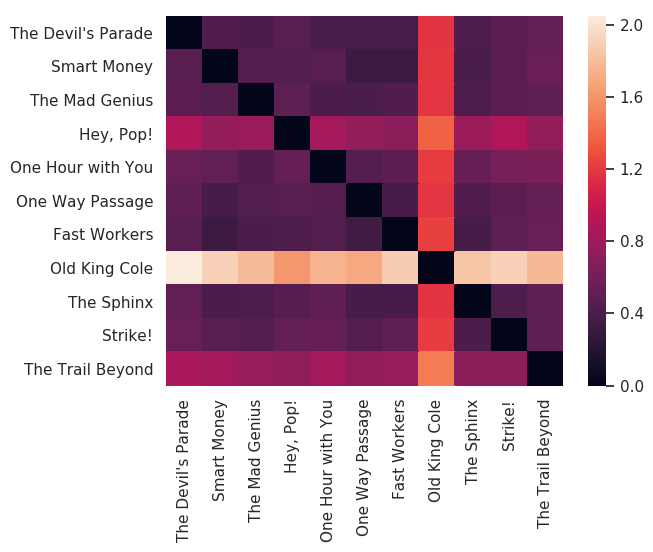

In [115]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()


To reveal more patterns, let's do a multidimensional scaling of the matrix.

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


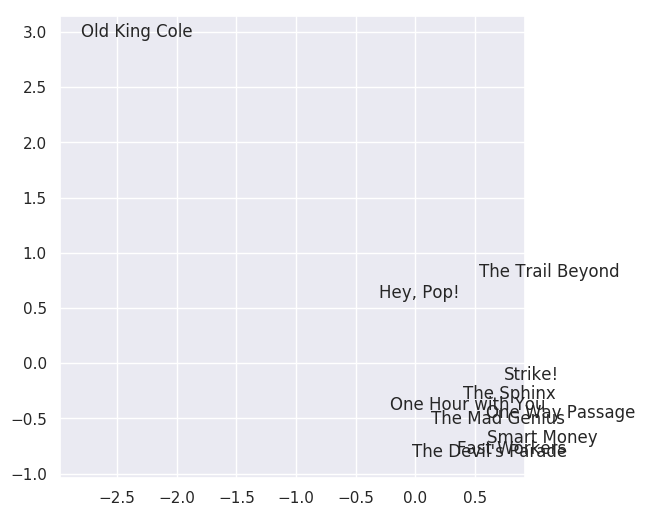

In [116]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

A co-respondent's course and The Chain Gang are away from the others - any guesses why?

We may just want to focus on the distrbution of stopwords or non-stopwords. Let's do the analysis again first for stopwords and then for non-stopwords.

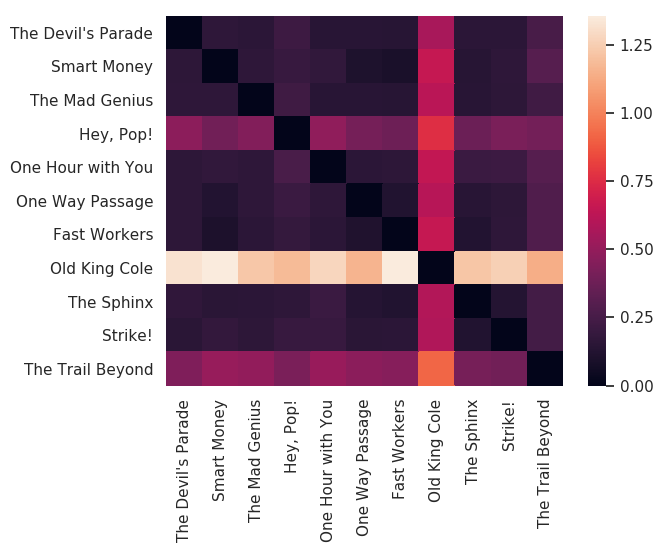

In [117]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

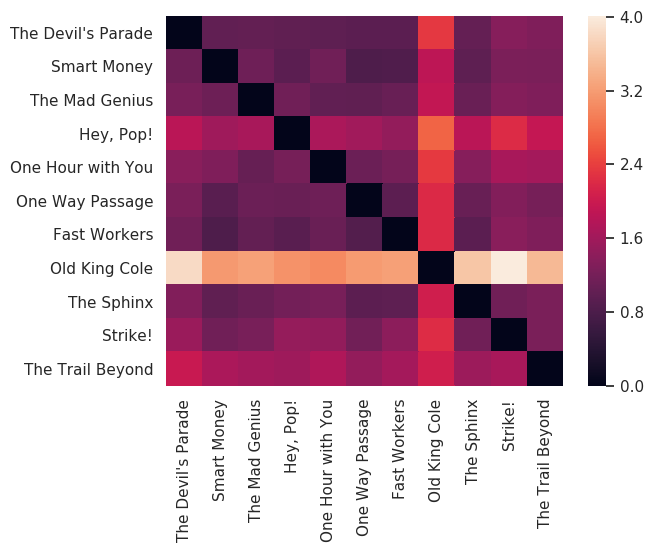

In [118]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

Now we compute the same for the assymmetric $\chi^2$ Divergence.

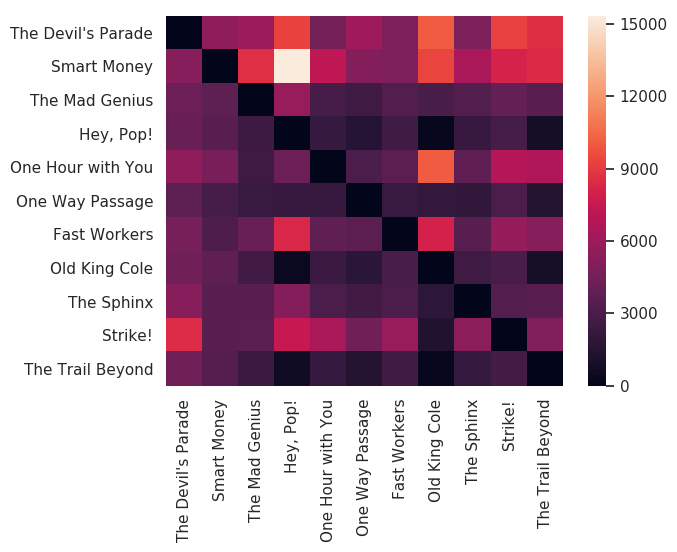

In [119]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

For the KS distance:

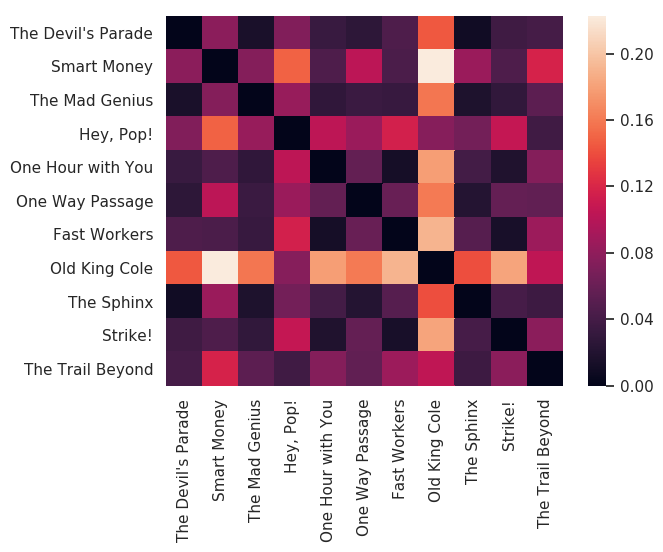

In [120]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

And finally for the Wasserstein or "earth mover's" Distance.

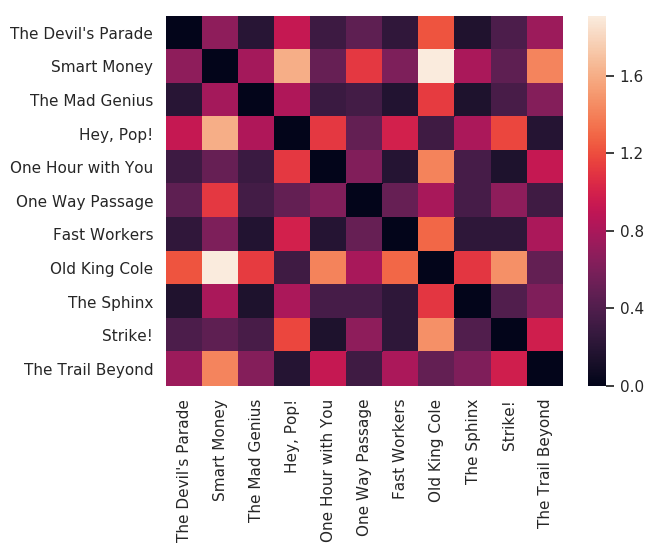

In [121]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

You can see that decade X is highly divergent and this makes reading the plot somewhat difficult. Let's fix this by taking the log of each cell, which will reduce the distance of decode X from other texts as an outlier.

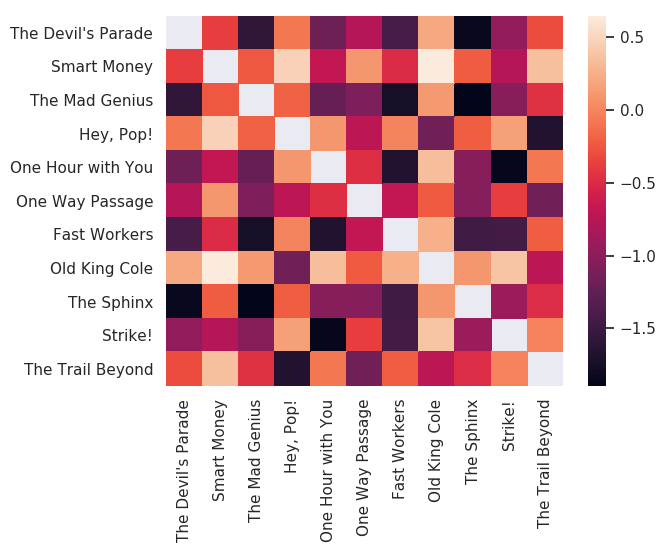

In [122]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

We only tried 11 movies, and from the same time period, so our signals might not be too interesting. What about different time periods?

An interesting experiment to maybe get some clearer signals: documents by decade in the Davies Corpus Of Historial American English (COHA) and see if we can detect patterns between them. 

If we want to rerun this on a new data set of our own composition, we can be a bit more efficient with our coding. Let's use the Shakespeare texts from last week as example: 

In [123]:
shakespeare_df = lucem_illud_2020.loadTextDirectory('../data/Shakespeare')

Now we stem and remove stopwords

In [124]:
shakespeare_df['tokenized_text'] = shakespeare_df['text'].apply(lambda x: word_tokenize(x))
shakespeare_df['normalized_tokens'] = shakespeare_df['tokenized_text'].apply(lambda x: normalizeTokens(x))

Create the corpus file and generate the heatmap:

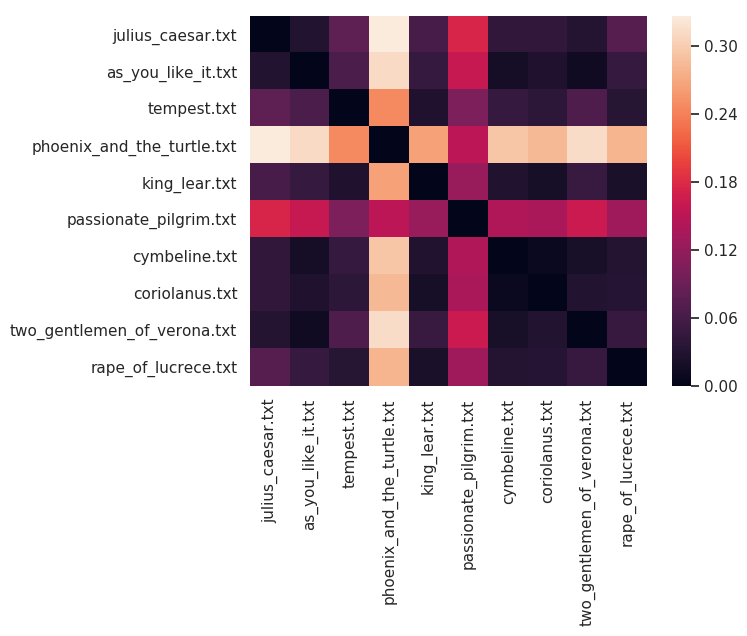

In [125]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 #The bigger this number the slower it will run, you can also try selecting your own plays
fileids_sp = list(shakespeare_df[:num_of_texts].index)
corpora_sp = list(shakespeare_df[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

What are "The Passionate Pilgrim" and "The Phoenix and the Turtle"? Little known poems by Shakespeare that are unsurprisingly hard to classify, as they are so different from everything else he wrote.

## <span style="color:red">*Exercise 6*</span>

<span style="color:red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better? 

<span style="color:red">**Stretch**: Calculate the <a "href=https://en.wikipedia.org/wiki/Jensen–Shannon_divergence" target="_blank">Jensen-Shannon Divergence</a> between your four corpora. What is the relationship between the KL and JS divergences?</span> 

In [190]:
df_con_NB = df_con[df_con['condition']=='NB']
df_con_NB

,condition,conversation_txt,con_txt_A,con_txt_B,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count,normalized_tokens_POS,sentences,POS_sents,classified_sents
11,NB,"Okay, so uh, I guess they said we should start...","Okay, so uh, I guess they said we should start...","Yea, we should start Um, yeah. I actually didn...","[Okay, so, uh, I, guess, they, said, we, shoul...",592,"[okay, uh, guess, say, start, yea, start, uh, ...",237,"[(okay, UH), (,, ,), (so, RB), (uh, UH), (,, ,...","[[Okay, so, uh, I, guess, they, said, we, shou...","[[(Okay, UH), (so, RB), (uh, UH), (I, PRP), (g...","[[], [], [], [], [], [], [], [], [], [], [], [..."
9,NB,"Uh, so, uh I-I actually uh read a lot about th...",Ok and so what does the law say? Does it say l...,"Uh, so, uh I-I actually uh read a lot about th...","[Uh, so, uh, I, I, actually, uh, read, a, lot,...",348,"[uh, uh, actually, uh, read, lot, topic, uh, u...",151,"[(uh, UH), (,, ,), (so, CC), (,, ,), (uh, UH),...","[[Uh, so, uh, I], [-I, actually, uh, read, a, ...","[[(Uh, UH), (so, RB), (uh, UH), (I, PRP), (-I,...","[[(the Supreme Court, ORG)], [], [], [], [], [..."
5,NB,"Yea, so so so. What do you--what do you person...","I think that the US, I answered that the US sh...","Yea, so so so. What do you--what do you person...","[Yea, so, so, so, What, do, you, what, do, you...",510,"[yea, personally, think, think, answer, lower,...",211,"[(yea, UH), (,, ,), (so, RB), (so, RB), (so, R...","[[Yea], [so, so, so], [What, do, you, what, do...","[[(Yea, RB)], [(so, RB)], [(so, RB), (so, RB),...","[[], [], [], [], [(US, GPE), (US, GPE)], [], [..."
4,NB,"Okay, um, so I put a four. I like very minorly...",I disagree. I put I put a 10 for this. And I...,"Okay, um, so I put a four. I like very minorly...","[Okay, um, so, I, put, a, four, I, like, very,...",374,"[okay, um, like, minorly, disagree, um, ok, de...",161,"[(okay, UH), (,, ,), (um, UH), (,, ,), (so, RB...","[[Okay, um, so, I, put, a, four], [I, like], [...","[[(Okay, UH), (um, UH), (so, RB), (I, PRP), (p...","[[(four, CARDINAL)], [], [], [], [], [], [], [..."
0,NB,"You want to go first? Or... Oh, because I feel...",You want to go first? Or... I disagree a littl...,"Oh, because I feel like it's possible for peop...","[You, want, to, go, first, Or, Oh, because, I,...",271,"[want, oh, feel, like, possible, people, mean,...",91,"[(you, PRP), (want, VBP), (to, TO), (go, VB), ...","[[You, want, to, go, first], [Or], [Oh, becaus...","[[(You, PRP), (want, VBP), (to, TO), (go, VB),...","[[(first, ORDINAL)], [], [], [], [], [], [], [..."


In [192]:
countTarget = 'UH'
targetCounts = {}
for entry in df_con_NB['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('like', 78),
 ('um', 23),
 ('uh', 16),
 ('Um', 7),
 ('Yeah', 7),
 ('yeah', 6),
 ('Like', 4),
 ('Ok', 3),
 ('Oh', 3),
 ('Okay', 2),
 ('Uh', 2),
 ('Well', 2),
 ('right', 2),
 ('anyway', 1),
 ('uhh--', 1),
 ('Sure', 1),
 ('oh', 1),
 ('Alright', 1),
 ('ok', 1),
 ('sure', 1)]

#### was interested in how filler word frequency differed by study condition (whether people used more affirming filler words in the TYB condition)

In [191]:
df_con_TYB = df_con[df_con['condition']=='TYB']
df_con_TYB

,condition,conversation_txt,con_txt_A,con_txt_B,tokenized_text,word_counts,normalized_tokens,normalized_tokens_count,normalized_tokens_POS,sentences,POS_sents,classified_sents
10,TYB,"So I don't really I think I said--yes, everyon...","So I don't really I think I said--yes, everyon...",I-I think put something that's below five.. Th...,"[So, I, do, n't, really, I, think, I, said, ye...",393,"[think, say, yes, think, oh, okay, uhhm, think...",144,"[(so, CC), (i, PRP), (do, VBP), (n't, RB), (re...","[[So, I, do, n't, really], [I, think, I, said-...","[[(So, RB), (I, PRP), (do, VBP), (n't, RB), (r...","[[], [], [], [], [(five, CARDINAL)], [(Three o..."
8,TYB,Okay so you--What's your opinion on this? I st...,Okay so you--What's your opinion on this? Oh w...,I strongly disagree with this I think you shou...,"[Okay, so, you, What, 's, your, opinion, on, t...",550,"[okay, opinion, strongly, disagree, oh, wow--,...",179,"[(okay, UH), (so, IN), (you, PRP), (--, :), (w...","[[Okay], [so, you, What, 's, your, opinion, on...","[[(Okay, UH)], [(so, IN), (you, PRP)], [(What,...","[[], [], [], [], [], [], [], [], [], [], [], [..."
7,TYB,"I'm good whenever you are Okay, let's start, y...","Okay, let's start, yea [laugh] Yeah, so um I t...","I'm good whenever you are So I guess like, wha...","[I, 'm, good, whenever, you, are, Okay, let, '...",230,"[m, good, okay, let, start, yea, laugh, guess,...",106,"[(i, PRP), ('m, VBP), (good, JJ), (whenever, W...","[[I, 'm, good, whenever, you, are, Okay, let, ...","[[(I, PRP), (', ``), (m, NN), (good, JJ), (whe...","[[], [], [], [], [], [], [], [], [], [], [], [..."
6,TYB,I just strongly believe in the right to um {{}...,I like what you said about like the right to. ...,I just strongly believe in the right to um {{}...,"[I, just, strongly, believe, in, the, right, t...",654,"[strongly, believe, right, um, dignity, yeah, ...",269,"[(i, PRP), (just, RB), (strongly, RB), (believ...","[[I, just, strongly, believe, in, the, right, ...","[[(I, PRP), (just, RB), (strongly, RB), (belie...","[[], [], [], [], [], [], [], [], [], [], [], [..."
3,TYB,"No. Yeah, that makes sense. And I, yeah, I app...","No. Yeah, that makes sense. And I, yeah, I app...",What do you know about herd immunity? Yeah.,"[No, Yeah, that, makes, sense, And, I, yeah, I...",229,"[yeah, make, sense, yeah, appreciate, sentimen...",99,"[(no, UH), (., .), (yeah, UH), (,, ,), (that, ...","[[No], [Yeah, that, makes, sense], [And, I, ye...","[[(No, UH)], [(Yeah, UH), (that, DT), (makes, ...","[[], [], [], [], [], [], [], [], [], [], [], [..."
2,TYB,"Oh, I think I strongly disagreed. Did you stro...","I agreed, yeah. Yeah. I definitely get what y...","Oh, I think I strongly disagreed. Did you stro...","[Oh, I, think, I, strongly, disagreed, Did, yo...",507,"[oh, think, strongly, disagree, strongly, agre...",213,"[(oh, UH), (,, ,), (i, PRP), (think, VBP), (i,...","[[Oh, I, think, I, strongly, disagreed], [Did,...","[[(Oh, UH), (I, PRP), (think, VBP), (I, PRP), ...","[[], [], [], [], [], [], [], [], [], [(Hyde Pa..."
1,TYB,"So I'm from a culture where, like a country wh...",So I appreciate that you bring up that there a...,"So I'm from a culture where, like a country wh...","[So, I, 'm, from, a, culture, where, like, a, ...",418,"[m, culture, like, country, capital, punishmen...",156,"[(so, CC), (i, PRP), ('m, VBP), (from, IN), (a...","[[So, I, 'm, from, a, culture, where, like, a,...","[[(So, CC), (I, PRP), (', ''), (m, NN), (from,...","[[], [], [], [], [], [], [], [], [], [], [(Yea..."


In [219]:
NBWords = set(df_con_NB['normalized_tokens'].sum())
TYBWords = set(df_con_TYB['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = NBWords & TYBWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student'] #why "student"?

51

In [213]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try:
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

NBProbArray = makeProbsArray(df_con_NB['normalized_tokens'], overlapWordsDict)
TYBProbArray = makeProbsArray(df_con_TYB['normalized_tokens'], overlapWordsDict)
TYBProbArray.sum()

0.9999999999999999

In [214]:
NB_TYBDivergence = scipy.stats.entropy(NBProbArray, TYBProbArray)
print(NB_TYBDivergence)
TYB_NBDivergence = scipy.stats.entropy(TYBProbArray, NBProbArray)
print(TYB_NBDivergence)

0.2641668287642121
0.24603906833805944


In [215]:
NB_TYBDivergence_ew = scipy.special.kl_div(NBProbArray, TYBProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = NB_TYBDivergence_ew
kl_df[:10]

,word,elementwise divergence
0,sort,0.000114
1,kind,0.005284
2,mm,0.000107
3,sense,0.006355
4,ok,0.010255
5,say,0.001465
6,time,0.000011
7,school,0.000343
8,help,0.006812
9,like,0.000041


In [216]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

,word,elementwise divergence
14,uhh,0.032034
45,life,0.018195
52,yeah,0.014323
84,perspective,0.014070
110,laugh,0.011981
4,ok,0.010255
43,go,0.008561
37,work,0.007672
63,talk,0.006812
8,help,0.006812


In [221]:
corpora = []
for index, row in df_con.iterrows():
    if len(corpora) > 10:
        break
    corpora.append(row['tokenized_text'])
corpora

[['Okay',
  'so',
  'uh',
  'I',
  'guess',
  'they',
  'said',
  'we',
  'should',
  'start',
  'Yea',
  'we',
  'should',
  'start',
  'So',
  'uh',
  'they',
  'said',
  'that',
  'this',
  'is',
  'a',
  'topic',
  'we',
  'disagreed',
  'on',
  'So',
  'I',
  "'m",
  'guessing',
  'you',
  'said',
  'that',
  'it',
  'should',
  "n't",
  'be',
  'abolished',
  'Um',
  'yeah',
  'Um',
  'I',
  'guess',
  'I',
  "'d",
  'like',
  'to',
  'hear',
  'you',
  'talk',
  'about',
  'it',
  'I',
  'actually',
  'did',
  "n't",
  'look',
  'much',
  'into',
  'the',
  'legal',
  'system',
  'here',
  'but',
  'for',
  'death',
  'penalty',
  'I',
  'think',
  'like',
  'if',
  'I',
  'think',
  'if',
  'someone',
  'committed',
  'to',
  'a',
  'really',
  'serious',
  'crime',
  'such',
  'as',
  'umm',
  'very',
  'like',
  'like',
  'murdering',
  'people',
  'and',
  'like',
  'not',
  'being',
  'regretful',
  'about',
  'that',
  'and',
  'then',
  'um',
  'like',
  'continuously',
 

In [223]:
corpora_s = []
corpora_nons = []
for corpus in df_con['tokenized_text']:
    s = []
    nons = []
    doc = nlp(' '.join(corpus))
    for word in doc:
        if word.is_stop:
            s.append(word.text)
        else:
            nons.append(word.text)
    corpora_s.append(s)
    corpora_nons.append(nons)

In [224]:
corpora_s

[['so',
  'I',
  'they',
  'we',
  'should',
  'we',
  'should',
  'So',
  'they',
  'that',
  'this',
  'is',
  'a',
  'we',
  'on',
  'So',
  'I',
  'you',
  'that',
  'it',
  'should',
  "n't",
  'be',
  'I',
  'I',
  "'d",
  'to',
  'you',
  'about',
  'it',
  'I',
  'did',
  "n't",
  'much',
  'into',
  'the',
  'here',
  'but',
  'for',
  'I',
  'if',
  'I',
  'if',
  'someone',
  'to',
  'a',
  'really',
  'serious',
  'such',
  'as',
  'very',
  'and',
  'not',
  'being',
  'about',
  'that',
  'and',
  'then',
  'doing',
  'a',
  'of',
  'that',
  'will',
  'the',
  'of',
  'the',
  'and',
  'also',
  'the',
  'around',
  'them',
  'I',
  'do',
  "n't",
  'there',
  'is',
  'any',
  'why',
  'this',
  'person',
  'could',
  'to',
  'in',
  'this',
  'I',
  'see',
  'what',
  'you',
  'what',
  'the',
  'I',
  'am',
  'against',
  'the',
  'is',
  "n't",
  'because',
  'I',
  'do',
  "n't",
  'some',
  'should',
  'be',
  'from',
  'because',
  'if',
  'you',
  'have',
  'someo

In [225]:
corpora_nons

[['Okay',
  'uh',
  'guess',
  'said',
  'start',
  'Yea',
  'start',
  'uh',
  'said',
  'topic',
  'disagreed',
  "'",
  'm',
  'guessing',
  'said',
  'abolished',
  'Um',
  'yeah',
  'Um',
  'guess',
  'like',
  'hear',
  'talk',
  'actually',
  'look',
  'legal',
  'system',
  'death',
  'penalty',
  'think',
  'like',
  'think',
  'committed',
  'crime',
  'umm',
  'like',
  'like',
  'murdering',
  'people',
  'like',
  'regretful',
  'um',
  'like',
  'continuously',
  'lot',
  'things',
  'harm',
  'security',
  'society',
  'people',
  'think',
  'reason',
  'continue',
  'live',
  'society',
  'Yeah',
  'like',
  'definitely',
  'like',
  'definitely',
  'mean',
  'reason',
  'personally',
  'death',
  'penalty',
  'think',
  'people',
  'removed',
  'society',
  'like',
  'like',
  'know',
  'like',
  'terrorist',
  'knows',
  'people',
  'indiscriminately',
  'like',
  'know',
  'think',
  'removed',
  'society',
  'time',
  'know',
  'terms',
  'like',
  'implementation',

In [226]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [227]:
len(df_con)

12

In [235]:
fileids = list(df_con['condition'])[0:12]
len(fileids)

12

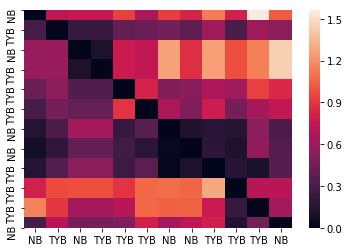

In [237]:
L = []
for p in df_con:
    l = []
    for q in df_con:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

### This heatmap should tell us whether we can accurately differentiate between the transcripts from the NB condition versus the transcripts from the TYB condition. As we saw in the Shakespeare heatplot, the parts of the graph that corresponded with anomalous Shakespearean works were lighter in color - here, it seems like we can generally differentiate between transcripts from NB and transcripts from TYB. The KL analysis distinguishses them quite well.

/Users/Sruti/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


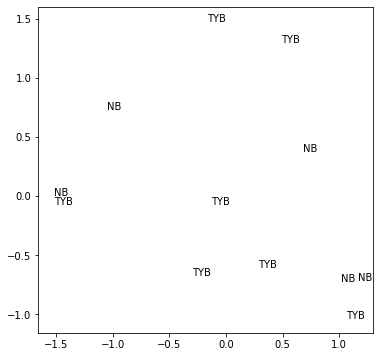

In [238]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

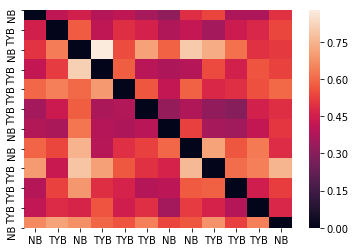

In [239]:
#Kullback-Leibler (KL) divergence - stop words
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

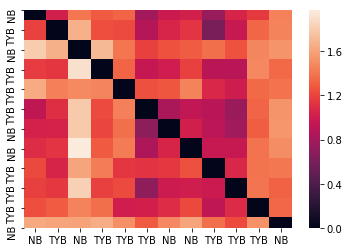

In [240]:
#Kullback-Leibler (KL) divergence - non stop words
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

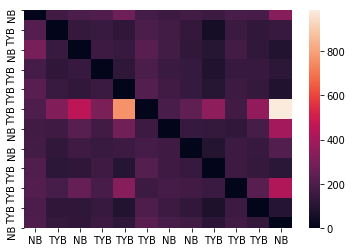

In [241]:
#assymmetric $\chi^2$ Divergence.
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

## This plot does not seem to disinguish the conditions very well.

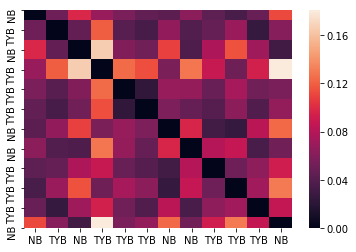

In [242]:
#KS distance
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

### This plot does not distinguish the conditions well, either.

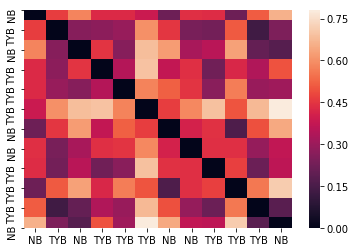

In [244]:
#Wasserstein distance
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

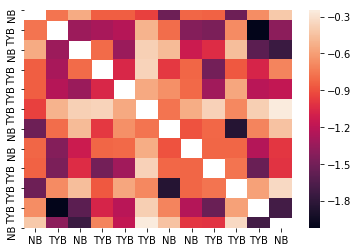

In [245]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

In [193]:
countTarget = 'UH'
targetCounts = {}
for entry in df_con_TYB['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('like', 85),
 ('Yeah', 28),
 ('um', 26),
 ('uh', 19),
 ('yeah', 19),
 ('Okay', 8),
 ('Um', 8),
 ('Oh', 6),
 ('Like', 4),
 ('okay', 3),
 ('Uh', 3),
 ('Well', 3),
 ('huh', 2),
 ('well', 2),
 ('Yea', 2),
 ('haha', 2),
 ('yes', 1),
 ('huh--', 1),
 ('eh', 1),
 ('Right', 1)]

In [201]:
berkeley_csv = pandas.read_csv('berkeley_compare.csv')
berkeley_csv #now, splitting the dataset into four separate parts to compare

,Conversation
0,"Person A: Okay, so in regard to the racial quo..."
1,"Person A: Okay. Hi.\nPerson B: Hi, what’s up?\..."
2,Person B: So I said that I do not want GMO pro...
3,Person B: So I said that I do not want GMO pro...
4,"Person A: Okay, so in regard to the racial quo..."
...,...
353,"Person A: All right, so I think that the age f..."
354,"Person B: Okay. So, the question is whether or..."
355,Person B: All right. I guess I don’t think I f...
356,"Person A: All right. Okay, so today we are tal..."


In [205]:
b_1 = berkeley_csv.iloc[:90]
b_1

,Conversation
0,"Person A: Okay, so in regard to the racial quo..."
1,"Person A: Okay. Hi.\nPerson B: Hi, what’s up?\..."
2,Person B: So I said that I do not want GMO pro...
3,Person B: So I said that I do not want GMO pro...
4,"Person A: Okay, so in regard to the racial quo..."
...,...
85,"Person B: All right, what's up man?\nPerson A:..."
86,Person A: Okay. So I believe that there should...
87,Person A: Okay. So I believe that there should...
88,Person B: Okay. So my stance is that the unive...


In [249]:
b_1['tokenized_text'] = b_1['Conversation'].apply(lambda x: word_tokenize(x))
b_1['normalized_tokens'] = b_1['tokenized_text'].apply(lambda x: normalizeTokens(x))

/Users/Sruti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/Sruti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [250]:
b_1

,Conversation,tokenized_text,normalized_tokens
0,"Person A: Okay, so in regard to the racial quo...","[Person, A, Okay, so, in, regard, to, the, rac...","[okay, regard, racial, quota, thing, personall..."
1,"Person A: Okay. Hi.\nPerson B: Hi, what’s up?\...","[Person, A, Okay, Hi, Person, B, Hi, what, ’s,...","[okay, hi, b, hi, yeah, position, want, lower,..."
2,Person B: So I said that I do not want GMO pro...,"[Person, B, So, I, said, that, I, do, not, wan...","[b, say, want, gmo, produce, cafeteria, inform..."
3,Person B: So I said that I do not want GMO pro...,"[Person, B, So, I, said, that, I, do, not, wan...","[b, say, want, gmo, produce, cafeteria, inform..."
4,"Person A: Okay, so in regard to the racial quo...","[Person, A, Okay, so, in, regard, to, the, rac...","[okay, regard, racial, quota, thing, personall..."
...,...,...,...
85,"Person B: All right, what's up man?\nPerson A:...","[Person, B, All, right, what, 's, up, man, Per...","[b, right, man, go, b, good, okay, say, people..."
86,Person A: Okay. So I believe that there should...,"[Person, A, Okay, So, I, believe, that, there,...","[okay, believe, type, racial, quota, employ, u..."
87,Person A: Okay. So I believe that there should...,"[Person, A, Okay, So, I, believe, that, there,...","[okay, believe, type, racial, quota, employ, u..."
88,Person B: Okay. So my stance is that the unive...,"[Person, B, Okay, So, my, stance, is, that, th...","[b, okay, stance, university, use, racial, quo..."


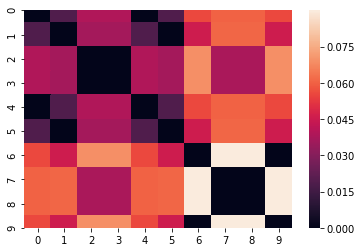

In [255]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 
fileids_sp = list(b_1[:num_of_texts].index) #what is this doing? :num_of_texts ?
corpora_sp = list(b_1[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

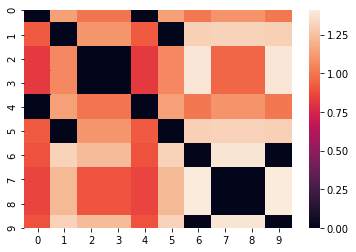

In [286]:
measure = "KL"
num_of_texts = 10 
fileids_sp = list(b_1[:num_of_texts].index)
corpora_sp = list(b_1[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

/Users/Sruti/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


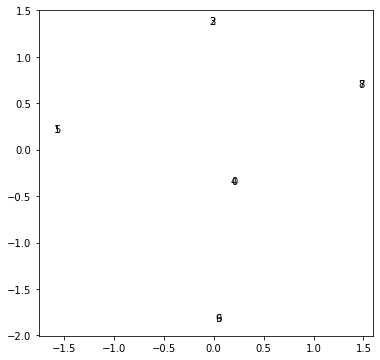

In [288]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids_sp):
    ax.annotate(txt, (x[i],y[i]))

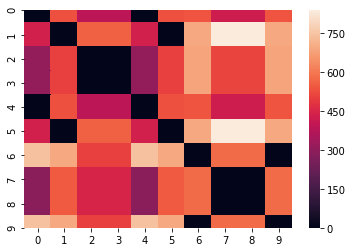

In [257]:
measure = "Chi2"
num_of_texts = 10 
fileids_sp = list(b_1[:num_of_texts].index)
corpora_sp = list(b_1[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

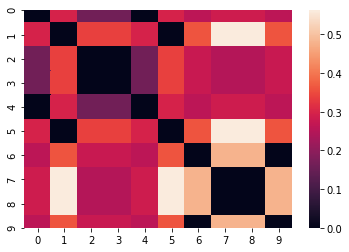

In [258]:
measure = "Wasserstein"
num_of_texts = 10 
fileids_sp = list(b_1[:num_of_texts].index)
corpora_sp = list(b_1[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

In [207]:
b_2 = berkeley_csv.iloc[90:181]
b_2

,Conversation
90,Person A: I believe that some racial quotas (~...
91,Person A: UC Berkeley should decide to provide...
92,Person A: UC Berkeley should decide to provide...
93,Person A: I believe that some racial quotas (~...
94,Person A: Many minorities come from disadvanta...
...,...
176,Person B: I do not think that there should be ...
177,Person B: I feel that the drinking age in Amer...
178,"Person B: Okay, so our topic is on legal drink..."
179,"Person A: All right, so our topic is if GMO pr..."


In [251]:
b_2['tokenized_text'] = b_2['Conversation'].apply(lambda x: word_tokenize(x))
b_2['normalized_tokens'] = b_2['tokenized_text'].apply(lambda x: normalizeTokens(x))
b_2

/Users/Sruti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/Sruti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Conversation,tokenized_text,normalized_tokens
90,Person A: I believe that some racial quotas (~...,"[Person, A, I, believe, that, some, racial, qu...","[believe, racial, quota, establish, admission,..."
91,Person A: UC Berkeley should decide to provide...,"[Person, A, UC, Berkeley, should, decide, to, ...","[uc, berkeley, decide, provide, combination, g..."
92,Person A: UC Berkeley should decide to provide...,"[Person, A, UC, Berkeley, should, decide, to, ...","[uc, berkeley, decide, provide, combination, g..."
93,Person A: I believe that some racial quotas (~...,"[Person, A, I, believe, that, some, racial, qu...","[believe, racial, quota, establish, admission,..."
94,Person A: Many minorities come from disadvanta...,"[Person, A, Many, minorities, come, from, disa...","[minority, come, disadvantaged, background, sc..."
...,...,...,...
176,Person B: I do not think that there should be ...,"[Person, B, I, do, not, think, that, there, sh...","[b, think, racially, base, quota, believe, peo..."
177,Person B: I feel that the drinking age in Amer...,"[Person, B, I, feel, that, the, drinking, age,...","[b, feel, drinking, age, america, recall, corr..."
178,"Person B: Okay, so our topic is on legal drink...","[Person, B, Okay, so, our, topic, is, on, lega...","[b, okay, topic, legal, drinking, age, student..."
179,"Person A: All right, so our topic is if GMO pr...","[Person, A, All, right, so, our, topic, is, if...","[right, topic, gmo, produce, berkeley, cafeter..."


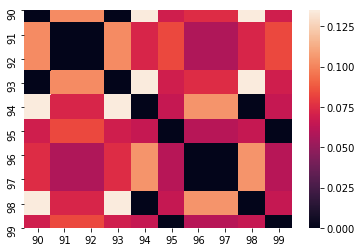

In [274]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 
fileids_sp = list(b_2[:num_of_texts].index) #what is this doing? :num_of_texts ?
corpora_sp = list(b_2[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

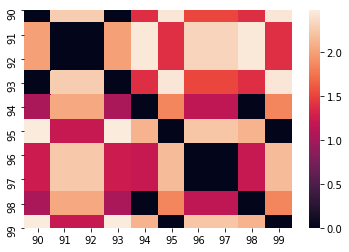

In [289]:
measure = "KL"
num_of_texts = 10 
fileids_sp = list(b_2[:num_of_texts].index) #what is this doing? :num_of_texts ?
corpora_sp = list(b_2[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

/Users/Sruti/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


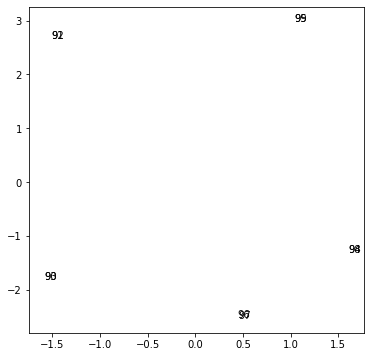

In [290]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids_sp):
    ax.annotate(txt, (x[i],y[i]))

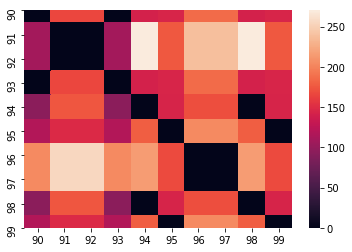

In [276]:
measure = "Chi2"
num_of_texts = 10 
fileids_sp = list(b_2[:num_of_texts].index) #what is this doing? :num_of_texts ?
corpora_sp = list(b_2[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

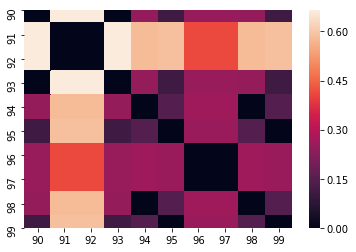

In [277]:
measure = "Wasserstein"
num_of_texts = 10 
fileids_sp = list(b_2[:num_of_texts].index) #what is this doing? :num_of_texts ?
corpora_sp = list(b_2[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

In [210]:
b_3 = berkeley_csv.iloc[181:270]
b_3

,Conversation
181,Person A: Hello. So I’m going to talk about GM...
182,"Person B: Okay, so I do not believe that Berke..."
183,"Person A: Okay, so I guess that Berkeley shoul..."
184,"Person B: Okay, so our topic is on legal drink..."
185,"Person A: Okay, so I guess that Berkeley shoul..."
...,...
265,"Person A: All right, so I have five main point..."
266,Person A: Hi. Okay. So we're talking about adm...
267,Person A: Hi. Okay. So we're talking about adm...
268,Person A: So over 400 years of systematic and ...


In [252]:
b_3['tokenized_text'] = b_3['Conversation'].apply(lambda x: word_tokenize(x))
b_3['normalized_tokens'] = b_3['tokenized_text'].apply(lambda x: normalizeTokens(x))

/Users/Sruti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/Sruti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [253]:
b_3

,Conversation,tokenized_text,normalized_tokens
181,Person A: Hello. So I’m going to talk about GM...,"[Person, A, Hello, So, I, ’m, going, to, talk,...","[hello, m, go, talk, gmos, think, gmo, possibl..."
182,"Person B: Okay, so I do not believe that Berke...","[Person, B, Okay, so, I, do, not, believe, tha...","[b, okay, believe, berkeley, rely, race, quota..."
183,"Person A: Okay, so I guess that Berkeley shoul...","[Person, A, Okay, so, I, guess, that, Berkeley...","[okay, guess, berkeley, lower, drinking, age, ..."
184,"Person B: Okay, so our topic is on legal drink...","[Person, B, Okay, so, our, topic, is, on, lega...","[b, okay, topic, legal, drinking, age, student..."
185,"Person A: Okay, so I guess that Berkeley shoul...","[Person, A, Okay, so, I, guess, that, Berkeley...","[okay, guess, berkeley, lower, drinking, age, ..."
...,...,...,...
265,"Person A: All right, so I have five main point...","[Person, A, All, right, so, I, have, five, mai...","[right, main, point, think, uc, berkeley, admi..."
266,Person A: Hi. Okay. So we're talking about adm...,"[Person, A, Hi, Okay, So, we, 're, talking, ab...","[hi, okay, talk, admission, quota, think, quot..."
267,Person A: Hi. Okay. So we're talking about adm...,"[Person, A, Hi, Okay, So, we, 're, talking, ab...","[hi, okay, talk, admission, quota, think, quot..."
268,Person A: So over 400 years of systematic and ...,"[Person, A, So, over, 400, years, of, systemat...","[year, systematic, pervasive, institutional, r..."


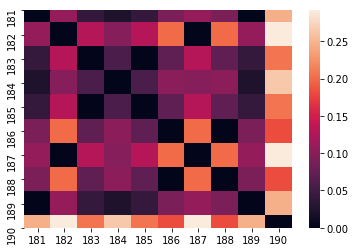

In [278]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 
fileids_sp = list(b_3[:num_of_texts].index) #what is this doing? :num_of_texts ?
corpora_sp = list(b_3[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

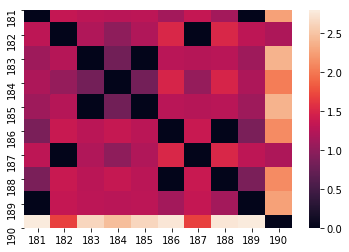

In [291]:
measure = "KL"
num_of_texts = 10 
fileids_sp = list(b_3[:num_of_texts].index) #what is this doing? :num_of_texts ?
corpora_sp = list(b_3[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

/Users/Sruti/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


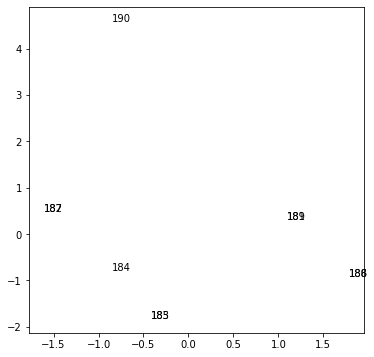

In [292]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids_sp):
    ax.annotate(txt, (x[i],y[i]))

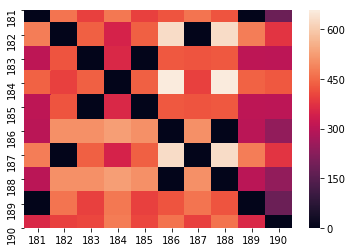

In [280]:
measure = "Chi2" 
num_of_texts = 10 
fileids_sp = list(b_3[:num_of_texts].index) #what is this doing? :num_of_texts ?
corpora_sp = list(b_3[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

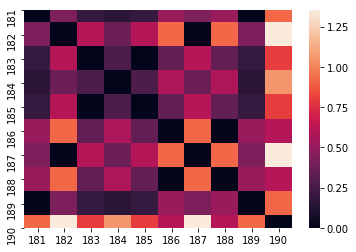

In [281]:
measure = "Wasserstein"
num_of_texts = 10 
fileids_sp = list(b_3[:num_of_texts].index) #what is this doing? :num_of_texts ?
corpora_sp = list(b_3[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

In [211]:
b_4 = berkeley_csv.iloc[270:]
b_4

,Conversation
270,"Person A: To answer the question, I think that..."
271,"Person A: To answer the question, I think that..."
272,Person A: GMOs should be implemented in UC Ber...
273,"Person B: To begin, the legal drinking age sho..."
274,Person A: GMO-produce should be made available...
...,...
353,"Person A: All right, so I think that the age f..."
354,"Person B: Okay. So, the question is whether or..."
355,Person B: All right. I guess I don’t think I f...
356,"Person A: All right. Okay, so today we are tal..."


In [254]:
b_4['tokenized_text'] = b_4['Conversation'].apply(lambda x: word_tokenize(x))
b_4['normalized_tokens'] = b_4['tokenized_text'].apply(lambda x: normalizeTokens(x))
b_4

/Users/Sruti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/Sruti/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Conversation,tokenized_text,normalized_tokens
270,"Person A: To answer the question, I think that...","[Person, A, To, answer, the, question, I, thin...","[answer, question, think, berkeley, decision, ..."
271,"Person A: To answer the question, I think that...","[Person, A, To, answer, the, question, I, thin...","[answer, question, think, berkeley, decision, ..."
272,Person A: GMOs should be implemented in UC Ber...,"[Person, A, GMOs, should, be, implemented, in,...","[gmos, implement, uc, berkeley, cafeteria, for..."
273,"Person B: To begin, the legal drinking age sho...","[Person, B, To, begin, the, legal, drinking, a...","[b, begin, legal, drinking, age, change, dange..."
274,Person A: GMO-produce should be made available...,"[Person, A, GMO, produce, should, be, made, av...","[gmo, produce, available, uc, berkeley, colleg..."
...,...,...,...
353,"Person A: All right, so I think that the age f...","[Person, A, All, right, so, I, think, that, th...","[right, think, age, drinking, change, feel, li..."
354,"Person B: Okay. So, the question is whether or...","[Person, B, Okay, So, the, question, is, wheth...","[b, okay, question, uc, berkeley, decide, use,..."
355,Person B: All right. I guess I don’t think I f...,"[Person, B, All, right, I, guess, I, do, n’t, ...","[b, right, guess, think, feel, strongly, way, ..."
356,"Person A: All right. Okay, so today we are tal...","[Person, A, All, right, Okay, so, today, we, a...","[right, okay, today, talk, legal, lower, legal..."


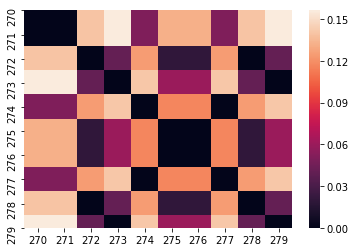

In [282]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 
fileids_sp = list(b_4[:num_of_texts].index) #what is this doing? :num_of_texts ?
corpora_sp = list(b_4[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

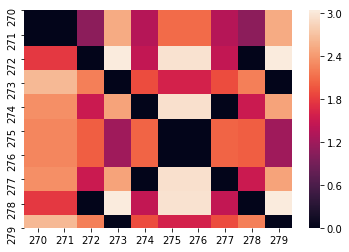

In [293]:
measure = "KL"
num_of_texts = 10 
fileids_sp = list(b_4[:num_of_texts].index) #what is this doing? :num_of_texts ?
corpora_sp = list(b_4[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

/Users/Sruti/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


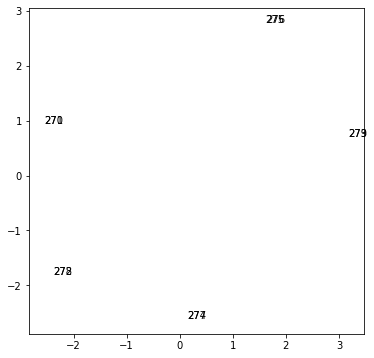

In [294]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids_sp):
    ax.annotate(txt, (x[i],y[i]))

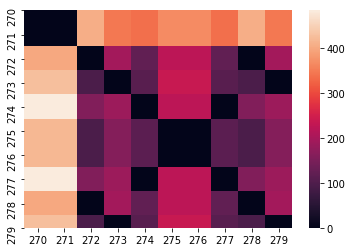

In [284]:
measure = "Chi2"
num_of_texts = 10 
fileids_sp = list(b_4[:num_of_texts].index) #what is this doing? :num_of_texts ?
corpora_sp = list(b_4[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

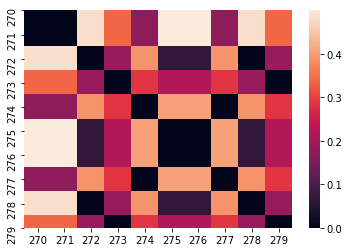

In [285]:
measure = "Wasserstein"
num_of_texts = 10 
fileids_sp = list(b_4[:num_of_texts].index) #what is this doing? :num_of_texts ?
corpora_sp = list(b_4[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

In [296]:
#b1_b2 divergence 
b1Words = set(b_1['normalized_tokens'].sum())
b2Words = set(b_2['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = b1Words & b2Words

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student'] #why "student"?


b1ProbArray = makeProbsArray(b_1['normalized_tokens'], overlapWordsDict)
b2ProbArray = makeProbsArray(b_2['normalized_tokens'], overlapWordsDict)
b2ProbArray.sum()

1.0

In [297]:
b1_b2Divergence = scipy.stats.entropy(b1ProbArray, b2ProbArray)
print(b1_b2Divergence)
b2_b1Divergence = scipy.stats.entropy(b2ProbArray, b1ProbArray)
print(b2_b1Divergence)

0.1602569786708589
0.1727432354663243


In [299]:
b1_b2Divergence_ew = scipy.special.kl_div(b1ProbArray, b2ProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = b1_b2Divergence_ew
kl_df[:10]

kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

,word,elementwise divergence
747,student,0.003790
114,go,0.003148
679,race,0.003102
844,drink,0.002846
843,old,0.002731
197,hmm,0.001734
650,tell,0.001639
225,raise,0.001438
1105,think,0.001437
635,oh,0.001316


In [301]:
#b2_b3 divergence

b2Words = set(b_1['normalized_tokens'].sum())
b3Words = set(b_2['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = b2Words & b3Words

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student'] #why "student"?


b2ProbArray = makeProbsArray(b_2['normalized_tokens'], overlapWordsDict)
b3ProbArray = makeProbsArray(b_3['normalized_tokens'], overlapWordsDict)
b3ProbArray.sum()



1.0

In [302]:
b2_b3Divergence = scipy.stats.entropy(b2ProbArray, b3ProbArray)
print(b2_b3Divergence)
b3_b2Divergence = scipy.stats.entropy(b3ProbArray, b2ProbArray)
print(b3_b2Divergence)

b2_b3Divergence_ew = scipy.special.kl_div(b2ProbArray, b3ProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = b2_b3Divergence_ew
kl_df[:10]

kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

##Not sure what "inf" means here - didn't throw an error

inf
0.15724427918405784


,word,elementwise divergence
1141,marginalize,inf
152,ap,inf
407,eastern,inf
950,mental,inf
382,month,inf
961,vicious,inf
368,partner,inf
963,biased,inf
964,guidance,inf
965,goal,inf


In [304]:
#b3_b4 divergence

b3Words = set(b_1['normalized_tokens'].sum())
b4Words = set(b_2['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = b3Words & b4Words

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student'] #why "student"?


747

In [305]:
b3ProbArray = makeProbsArray(b_3['normalized_tokens'], overlapWordsDict)
b4ProbArray = makeProbsArray(b_4['normalized_tokens'], overlapWordsDict)
b4ProbArray.sum()



1.0

In [307]:
b3_b4Divergence_ew = scipy.special.kl_div(b3ProbArray, b4ProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = b3_b4Divergence_ew
kl_df[:10]

kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

##Not sure what "inf" means here - didn't throw an error

,word,elementwise divergence
400,tradition,inf
295,controversial,inf
1095,rage,inf
605,strive,inf
790,pest,inf
602,tobacco,inf
598,marketing,inf
1090,common,inf
245,saving,inf
595,adopt,inf
